Aynur Rahimova

**Evaluating the Impact of Semiconductor Adoption and Technological Change on Occupational Shifts and Workforce Displacement Across Major Industries**

***In this study, a supervised regression model will be implemented***

##### **Notebook "Modeling"** (part 3)

**Imports**

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt,textwrap
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter,MaxNLocator, EngFormatter,  LogLocator, NullFormatter, MultipleLocator
from matplotlib.offsetbox import TextArea, AnnotationBbox, AnchoredText
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerBase
from matplotlib.gridspec import GridSpec
from matplotlib.axes import Axes
from matplotlib import colors as mcolors
from matplotlib.colors import TwoSlopeNorm, to_rgb
from textwrap import wrap, shorten
import textwrap
import re
from IPython.display import display, Markdown
import collections
import os, json
from math import ceil
import category_encoders as ce
import optuna
import shap
import joblib
import pickle
from optuna.samplers import TPESampler
import h2o
from h2o.automl import H2OAutoML
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from collections import OrderedDict
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import learning_curve
from flaml import AutoML
import re

In [3]:
TITLE_CLR     = "#2B2B2B"  # strong but not black
SUBTITLE_CLR  = "#666666"  # medium contrast, elegant
AXIS_TEXT_CLR = "#595959"  # matches main chart labels
FOOTNOTE_CLR  = "#777777"  # lighter for low emphasis

**The "df_model" dataset was selected as the final input for model development**

In [ ]:
path_model = "../Data/Processed/df_model.csv"
df_ml_model = pd.read_csv(path_model)

In [ ]:
df_ml = df_ml_model.copy()  # to avoid modifying the DataFrame df_ml_model

In [ ]:
# A final review of the dataset prepared for modeling
df_ml.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169985 entries, 0 to 169984
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Employment_Growth               169985 non-null  float64
 1   log_Trade_Value_usd             169985 non-null  float64
 2   log_Alternative_Quantity_Value  160043 non-null  float64
 3   log_Net_Weight_Estimated        169985 non-null  float64
 4   log_Gross_Weight_Estimated      169985 non-null  float64
 5   log_RD_Expenditure_GDP_Percent  131780 non-null  float64
 6   Occupation                      169985 non-null  object 
 7   Country                         169985 non-null  object 
 8   Gender                          169985 non-null  object 
 9   Partner_Code                    169985 non-null  object 
 10  Commodity_Type                  169985 non-null  object 
 11  Trade_Value_Is_Estimated        169985 non-null  bool   
 12  Gross_Weight_Is_

In [37]:
df_ml.head()  # to check the first few rows of the dataframe

,log_Employment_Growth,log_Trade_Value_usd,log_Alternative_Quantity_Value,log_Net_Weight_Estimated,log_Gross_Weight_Estimated,log_RD_Expenditure_GDP_Percent,Occupation,Country,Gender,Partner_Code,Commodity_Type,Trade_Value_Is_Estimated,Gross_Weight_Is_Estimated,Alt_Quantity_Is_Estimated,RD_Missing_Flag,AlternativeQty_Missing_Flag,Year_Group
0,-0.105422,7.036148,5.676754,0.0,0.0,NaN,Occupation (ISCO-08): 0. Armed forces occupations,Albania,Male,H3,Electronic integrated circuits,False,False,True,1,0,Early 2010s
1,-0.279833,9.876476,7.211557,0.0,0.0,NaN,Occupation (ISCO-08): 0. Armed forces occupations,Albania,Total,H4,"Diodes, transistors, similar semiconductor dev...",False,False,True,1,0,Early 2010s
2,-0.026937,9.876476,7.211557,0.0,0.0,NaN,Occupation (ISCO-08): 0. Armed forces occupations,Albania,Male,H4,"Diodes, transistors, similar semiconductor dev...",False,False,True,1,0,Early 2010s
3,0.027683,10.828342,3.258097,0.0,0.0,NaN,Occupation (ISCO-08): 0. Armed forces occupations,Albania,Total,H4,Electronic integrated circuits,False,False,True,1,0,Early 2010s
4,-0.026937,10.828342,3.258097,0.0,0.0,NaN,Occupation (ISCO-08): 0. Armed forces occupations,Albania,Male,H4,Electronic integrated circuits,False,False,True,1,0,Early 2010s


**Handling Missing values**:

For Baseline model, GradientBoostingRegressor and Random Forest Regressor Missing values will be imputed with 0 (0 reflects "non-active in technology progress");

For Gradient Boosting  (XGBoost, LightGBM, CatBoost) Missing values will not be imputed. They can handle missing values.

'RD_Expenditure_GDP_Percent's and 'log_Alternative_Quantity_Value's Missing values are handled respectively by 'RD_Missing_Flag' and 'AlternativeQty_Missing_Flag'.

**Checking Cardinality of categorical features**

to understand how they should be encoded

In [38]:
# to chek for high cardinality features that may need special handling

check_high_cardinality = [
    'Occupation',
    'Country',
    'Partner_Code', 
    'Commodity_Type',   
    'Year_Group'  
]                                                                                 

# Print unique values for each selected feature
for feature in check_high_cardinality:
    unique_vals = df_ml[feature].nunique()
    print(f"\nUnique values in '{feature}' {unique_vals} total:")
    print(unique_vals)


Unique values in 'Occupation' 28 total:
28

Unique values in 'Country' 130 total:
130

Unique values in 'Partner_Code' 7 total:
7

Unique values in 'Commodity_Type' 5 total:
5

Unique values in 'Year_Group' 4 total:
4


'Partner_Code', 'Commodity_Type', 'Year_Group' have Low cardinality, so they can be encoded by One-Hot encoding.

'Occupation' has Medium, 'Country' - High cardinality. Tree-based models handle this well with target encoding.

**Scaling**

Numerical features even after log-transformation are skewed, have outliers. Robust Scaler is resistant to outliers and skewness.

So, RobustScaler will be applied for all numerical features for Ridge.

Tree-based models do not require scaling.

**Dimensionality reduction**:

For Ridge TruncatedSVD will be used to reduce dimensionality and multicollinearity.

Tree-based models do not require dimensionality reduction. They handle high-dimensional, sparse, and correlated features natively.

It will be 4 Feature Pipelines created for Baseline model and Advanced models

In [39]:
# Defining feature groups
numeric_features = [
    'log_Trade_Value_usd', 'log_Alternative_Quantity_Value',
    'log_Net_Weight_Estimated', 'log_Gross_Weight_Estimated',
    'log_RD_Expenditure_GDP_Percent'                             
]

# Country = high-cardinality (target encoded)
target_encoded_feature = ['Country', 'Occupation']

# Other categorical features (safe for one-hot)
onehot_categorical_features = ['Partner_Code', 'Commodity_Type', 'Gender', 'Year_Group']

# Binary flags
binary_flag_features = [
    'Trade_Value_Is_Estimated', 'Gross_Weight_Is_Estimated',
    'Alt_Quantity_Is_Estimated', 'RD_Missing_Flag', 'AlternativeQty_Missing_Flag'
]

features_for_modeling = numeric_features + target_encoded_feature + onehot_categorical_features + binary_flag_features

Now I will check whether help this feature engineering to improve scores.

I tried later these feature engineering. It was no any change in results observed. So, they will no be used

In [ ]:
# df_ml['log_Value_per_Weight'] = df_ml['log_Trade_Value_usd'] * df_ml['log_Gross_Weight_Estimated']

# from itertools import combinations

# for f1, f2 in combinations(numeric_features, 2):
#     interaction_name = f"{f1}_x_{f2}"
#     df_ml[interaction_name] = df_ml[f1] * df_ml[f2]

# new_interactions = [col for col in df_ml.columns if '_x_' in col or '_per_' in col]
# features_for_modeling += new_interactions

In [41]:
# Define X (features) and y (target) for modeling

X = df_ml[features_for_modeling]
y = df_ml['log_Employment_Growth']

In [42]:
# Splitting data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # splitting before target_encoding to avoid data leakage

In [43]:
# Numerical pipelines:

num_pip = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))  # Impute missing values with 0
])

num_pip_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Impute missing values with 0, RobustScaler will handle outliers.
    ('scaler', RobustScaler())         
])

# Categorical pipelines: 
cat_pip = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

target_pip = Pipeline([                                     
    ('target_encoder', ce.TargetEncoder(
        handle_unknown='value',  # avoid error on unseen test categories
        return_df=False,
        smoothing=0.3))
])  

In [44]:
num_pip

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant'))])

In [45]:
num_pip_ridge

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('scaler', RobustScaler())])

In [46]:
cat_pip

Pipeline(steps=[('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [47]:
target_pip

Pipeline(steps=[('target_encoder',
                 TargetEncoder(return_df=False, smoothing=0.3))])

In [48]:
# will be used for GradientBoostingRegressor and Random Forest Regressor

baseline_preprocessor = ColumnTransformer(transformers=[
    ('num', num_pip, numeric_features),                                                  
    ('onehot_cat', cat_pip, onehot_categorical_features),
    ('country_enc', target_pip, target_encoded_feature),
    ('bin', 'passthrough', binary_flag_features)
])

In [49]:
# will be used for Ridge

ridge_preprocessor = ColumnTransformer(transformers=[
    ('num', num_pip_ridge, numeric_features),                                                  
    ('onehot_cat', cat_pip, onehot_categorical_features),
    ('country_enc', target_pip, target_encoded_feature),
    ('bin', 'passthrough', binary_flag_features)
])

In [50]:
# will be used for other tree-based models

tree_preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),                    
    ('onehot_cat', cat_pip, onehot_categorical_features),
    ('target_enc', target_pip, target_encoded_feature),
    ('bin', 'passthrough', binary_flag_features)
])

In [52]:
# Random Forest
rf = Pipeline([                           # Random Forest does not require scaling, but requires imputing. So, baseline_preprocessor is applied 
    ('preprocessor', baseline_preprocessor),   
    ('model', RandomForestRegressor(random_state=42))
])

# Gradient Boosting 
gb = Pipeline([                             # Gradient Boosting does not require scaling, but requires imputing. So, baseline_preprocessor is applied 
    ('preprocessor',baseline_preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Histogram-based GB 
histgb = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# XGBoost
xgb = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

# LightGBM 
lgb = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# CatBoost
cat = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('model', CatBoostRegressor(random_state=42, verbose=0))
])

# PCA is not used, it causes issues with Ridge  
ridge = Pipeline([
    ('preprocessor', ridge_preprocessor),
    ('svd', TruncatedSVD(n_components=20, random_state = 42)),  
    ('model', Ridge())
])

In [53]:
# Define all models in a loopable dictionary
models = OrderedDict({
    'Ridge': ridge,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Histogram GB': histgb,
    'XGBoost': xgb,
    'LightGBM': lgb,
    'CatBoost': cat,
})

In [54]:
# Evaluate models using metrics - R², RMSE and MAE
results = []

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # R²
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # RMSE
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Append results
    results.append({
        'Model': name,
        'R² Train': round(r2_train, 4),
        'R² Test': round(r2_test, 4),
        'RMSE Train': round(rmse_train, 4),
        'RMSE Test': round(rmse_test, 4),
        'MAE Train': round(mae_train, 4),
        'MAE Test': round(mae_test, 4)
    })

    # Print output
    print(f"{name}")
    print(f"   R²    : Train = {r2_train:.4f}, Test = {r2_test:.4f}")
    print(f"   RMSE  : Train = {rmse_train:.4f}, Test = {rmse_test:.4f}")
    print(f"   MAE   : Train = {mae_train:.4f}, Test = {mae_test:.4f}\n")


Ridge
   R²    : Train = 0.5786, Test = 0.5769
   RMSE  : Train = 0.5146, Test = 0.5181
   MAE   : Train = 0.3478, Test = 0.3491

Random Forest
   R²    : Train = 0.9931, Test = 0.9542
   RMSE  : Train = 0.0658, Test = 0.1704
   MAE   : Train = 0.0189, Test = 0.0500

Gradient Boosting
   R²    : Train = 0.7690, Test = 0.7707
   RMSE  : Train = 0.3810, Test = 0.3814
   MAE   : Train = 0.2418, Test = 0.2419

Histogram GB
   R²    : Train = 0.8908, Test = 0.8830
   RMSE  : Train = 0.2619, Test = 0.2725
   MAE   : Train = 0.1535, Test = 0.1567

XGBoost
   R²    : Train = 0.9241, Test = 0.9100
   RMSE  : Train = 0.2183, Test = 0.2390
   MAE   : Train = 0.1219, Test = 0.1286

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,007827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 135

Linear baseline model Ridge did not perform well. **Random forest Regressor model gives much better results** but showing some overfitting. I’ll work on reducing overfitting to make the model more reliable.

**Cross validation will be applied on Random Forest**, due to it shows the best scores, to prevent overfitting and get reliable results. After, will hyperparameter tuning on the chosen final model be applied to get best scores for the best model.

In [55]:
# Perform 5-fold cross-validation for Random Forest Regressor
cv_results_rf = cross_validate(
    rf,               # full pipeline
    X_train, y_train,              # raw features and target
    cv=5,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    },
    return_train_score=True
)

# Flip negatives for RMSE and MAE
rmse_train = -cv_results_rf['train_rmse'].mean()
rmse_test = -cv_results_rf['test_rmse'].mean()
mae_train = -cv_results_rf['train_mae'].mean()
mae_test = -cv_results_rf['test_mae'].mean()

r2_train = cv_results_rf['train_r2'].mean()
r2_test = cv_results_rf['test_r2'].mean()

# Print summary
print(f"Cross-Validated Scores for Random Forest:")
print(f"R²     : Train = {r2_train:.4f}, Test = {r2_test:.4f}")
print(f"RMSE   : Train = {rmse_train:.4f}, Test = {rmse_test:.4f}")
print(f"MAE    : Train = {mae_train:.4f}, Test = {mae_test:.4f}")



Cross-Validated Scores for Random Forest:
R²     : Train = 0.9925, Test = 0.9450
RMSE   : Train = 0.0689, Test = 0.1859
MAE    : Train = 0.0215, Test = 0.0578


The model perfomance on unseen data slightly lower than on training data. There is overfitting for my best model Random Forest.

I will build a Random Forest model and use its feature importance scores to evaluate which variables contribute most to predicting Employment_Growth(log).

* **Feature importances for Random Forest**

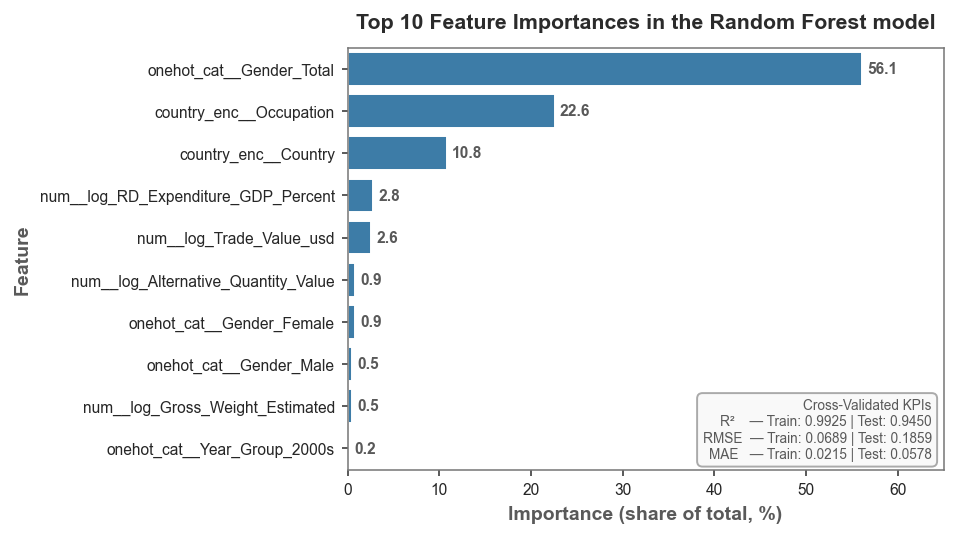

Saved tables:
 - rf_feature_importances_percent_all.csv
 - rf_feature_importances_percent_top10.csv


In [66]:
# ==========================================================
# Feature Importance (share of total %) + KPI box
# ==========================================================
# --- Fit & extract from pipeline ---
rf.fit(X_train, y_train)
rf_model = rf.named_steps['model']
importances = rf_model.feature_importances_
feature_names = rf.named_steps['preprocessor'].get_feature_names_out()

# --- Build importance table with % share ---
m = min(len(feature_names), len(importances))
feat_df = (
    pd.DataFrame({
        "Feature": np.asarray(feature_names)[:m],
        "Importance": np.asarray(importances)[:m]
    })
    .sort_values("Importance", ascending=False, ignore_index=True)
)

total = feat_df["Importance"].sum() or 1.0
feat_df["SharePct"] = 100 * feat_df["Importance"] / total
feat_df["CumSharePct"] = feat_df["SharePct"].cumsum()
feat_df["Rank"] = np.arange(1, len(feat_df) + 1)

# --- Plot Top-N as percent share ---
TOP_N = 10
plot_df = feat_df.head(TOP_N)  # keep descending order (top to bottom)

sns.set_theme(style="ticks") 
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=plot_df, x="SharePct", y="Feature", color="#2C7FB8", ax=ax, orient="h")

ax.tick_params(axis='y', labelsize = 8, which='both', length=3, width=1, color=AXIS_TEXT_CLR)   # ← adjust y-axis tick font size here
ax.tick_params(axis='x', labelsize = 8, which='both', length=3, width=1, color=AXIS_TEXT_CLR)   # ← adjust y-axis tick font size here

# --- Customize figure (axes) edge colors and thickness ---
for spine in ax.spines.values():
    spine.set_edgecolor(FOOTNOTE_CLR)   # light grey color
    spine.set_linewidth(0.8)         # thinner border

ax.grid(False)

ax.set_title(f"Top {TOP_N} Feature Importances in the Random Forest model", fontsize=11, pad=10, color = TITLE_CLR, weight = "bold")
ax.set_xlabel("Importance (share of total, %)", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")
ax.set_ylabel("Feature", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")

# percentage labels at end of each bar
xmax = plot_df["SharePct"].max()
for p, pct in zip(ax.patches, plot_df["SharePct"].values):
    ax.text(p.get_width() + xmax * 0.01,
            p.get_y() + p.get_height() / 2,
            f"{pct:.1f}",
            va="center", ha="left", fontsize=8, color=AXIS_TEXT_CLR, weight = "semibold")

# --- KPI box (R², RMSE, MAE) ---
kpi_text = (
    "Cross-Validated KPIs\n"
    f"R²    — Train: {r2_train:.4f} | Test: {r2_test:.4f}\n"
    f"RMSE  — Train: {rmse_train:.4f} | Test: {rmse_test:.4f}\n"
    f"MAE   — Train: {mae_train:.4f} | Test: {mae_test:.4f}"
)

ax.text(
    0.98, 0.02, kpi_text,
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=7, color = AXIS_TEXT_CLR,
    bbox=dict(boxstyle="round,pad=0.4", fc="#f9f9f9", ec="#aaaaaa")
)

ax.set_xlim(0, 65)
plt.tight_layout()
plt.show()

# --- Save DataFrames (full + Top-N) ---
feat_df.to_csv("rf_feature_importances_percent_all.csv", index=False)
feat_df.head(TOP_N).to_csv(f"rf_feature_importances_percent_top{TOP_N}.csv", index=False)

print("Saved tables:")
print(" - rf_feature_importances_percent_all.csv")
print(f" - rf_feature_importances_percent_top{TOP_N}.csv")

Feature Importances show that employment growth is most influenced by gender, the type of occupations, and the country itself. R&D and Trade factors matter, but less directly than workforce structure.

Trying to improve perfomance of model, **Random Forest** will be built **based on its Feature Importances**

In [67]:
# Defining feature groups                                         
numeric_features_rfi = ['log_Trade_Value_usd', 'log_Alternative_Quantity_Value', 'log_RD_Expenditure_GDP_Percent']

# Country = medium-cardinality (target encoded)
target_encoded_feature = ['Country', 'Occupation']

# Other categorical features (safe for one-hot)
onehot_categorical_features_rfi = ['Gender']

features_for_modeling_rfi = numeric_features_rfi + target_encoded_feature + onehot_categorical_features_rfi

In [68]:
# Define X (features) and y (target) for modeling

X_rfi = df_ml[features_for_modeling_rfi]
y_rfi = df_ml['log_Employment_Growth']

In [69]:
# Splitting into train and test sets

X_train_rfi, X_test_rfi, y_train_rfi, y_test_rfi = train_test_split(X_rfi, y_rfi, test_size=0.2, random_state=42)  # splitting before target_encoding to avoid data leakage

In [70]:
baseline_preprocessor_rfi = ColumnTransformer(transformers=[
    ('num', num_pip, numeric_features_rfi),                                                  
    ('onehot_cat', cat_pip, onehot_categorical_features_rfi),
    ('country_enc', target_pip, target_encoded_feature)
])

In [71]:
# Random Forest
rf_fi = Pipeline([                           
    ('preprocessor', baseline_preprocessor_rfi),   
    ('model', RandomForestRegressor(random_state=42))
])

In [72]:
# Evaluate models
name = 'Random Forest based on Feature Importance'
rf_fi.fit(X_train_rfi, y_train_rfi)

y_train_pred_rfi = rf_fi.predict(X_train_rfi)
y_test_pred_rfi = rf_fi.predict(X_test_rfi)

# R²
r2_train_rfi = r2_score(y_train_rfi, y_train_pred_rfi)
r2_test_rfi = r2_score(y_test_rfi, y_test_pred_rfi)

# RMSE
rmse_train_rfi = mean_squared_error(y_train_rfi, y_train_pred_rfi, squared=False)
rmse_test_rfi = mean_squared_error(y_test_rfi, y_test_pred_rfi, squared=False)

# MAE
mae_train_rfi = mean_absolute_error(y_train_rfi, y_train_pred_rfi)
mae_test_rfi = mean_absolute_error(y_test_rfi, y_test_pred_rfi)

# Print output
print(f"{name}")
print(f"   R²    : Train = {r2_train_rfi:.4f}, Test = {r2_test_rfi:.4f}")
print(f"   RMSE  : Train = {rmse_train_rfi:.4f}, Test = {rmse_test_rfi:.4f}")
print(f"   MAE   : Train = {mae_train_rfi:.4f}, Test = {mae_test_rfi:.4f}\n")


Random Forest based on Feature Importance
   R²    : Train = 0.9927, Test = 0.9525
   RMSE  : Train = 0.0678, Test = 0.1737
   MAE   : Train = 0.0197, Test = 0.0517



Random Forest with complete features_for_modeling:
   R²    : Train = 0.9931, Test = 0.9542
   RMSE  : Train = 0.0658, Test = 0.1704
   MAE   : Train = 0.0189, Test = 0.0500

Random Forest based on Feature Importance
   R²    : Train = 0.9927, Test = 0.9525
   RMSE  : Train = 0.0678, Test = 0.1737
   MAE   : Train = 0.0197, Test = 0.0517

This means even if some features have no high feature importance, they give signals those help to get higher score than without them.

So, Random Forest with complete features_for_modeling will be used further

Now I will build the **Random Forest** model using a feature set **without flag variables** to reduce potential noise, prevent overfitting, and make the model more robust and reliable. 

In [73]:
# define features for modeling without flag variables
features_for_modeling_no_flags = numeric_features + target_encoded_feature + onehot_categorical_features 

In [74]:
# Define X (features) and y (target) for modeling

X_no_flag = df_ml[features_for_modeling_no_flags]
y_no_flag = df_ml['log_Employment_Growth']

In [75]:
# Splitting into train and test sets

X_train_no_flag, X_test_no_flag, y_train_no_flag, y_test_no_flag = train_test_split(X_no_flag, y_no_flag, test_size=0.2, random_state=42)  # splitting before target_encoding to avoid data leakage

In [76]:
preprocessor_no_flag = ColumnTransformer(transformers=[
    ('num', num_pip, numeric_features),                                                  
    ('onehot_cat', cat_pip, onehot_categorical_features),
    ('country_enc', target_pip, target_encoded_feature),
])

In [77]:
# Random Forest
rf_no_flag = Pipeline([                           # Random Forest without flags
    ('preprocessor', preprocessor_no_flag),   
    ('model', RandomForestRegressor(random_state=42))
])

In [78]:
# Evaluate Random Forest without flags model
name = 'Random Forest_No_Flags'
rf_no_flag.fit(X_train_no_flag, y_train_no_flag)

y_train_pred_nof = rf_no_flag.predict(X_train_no_flag)
y_test_pred_nof = rf_no_flag.predict(X_test_no_flag)

# R²
r2_train_nof = r2_score(y_train_no_flag, y_train_pred_nof)
r2_test_nof = r2_score(y_test_no_flag, y_test_pred_nof)

# RMSE
rmse_train_nof = mean_squared_error(y_train_no_flag, y_train_pred_nof, squared=False)
rmse_test_nof = mean_squared_error(y_test_no_flag, y_test_pred_nof, squared=False)

# MAE
mae_train_nof = mean_absolute_error(y_train_no_flag, y_train_pred_nof)
mae_test_nof = mean_absolute_error(y_test_no_flag, y_test_pred_nof)

# Print output
print(f"{name}")
print(f"   R²    : Train = {r2_train_nof:.4f}, Test = {r2_test_nof:.4f}")
print(f"   RMSE  : Train = {rmse_train_nof:.4f}, Test = {rmse_test_nof:.4f}")
print(f"   MAE   : Train = {mae_train_nof:.4f}, Test = {mae_test_nof:.4f}\n")


Random Forest_No_Flags
   R²    : Train = 0.9931, Test = 0.9543
   RMSE  : Train = 0.0657, Test = 0.1703
   MAE   : Train = 0.0188, Test = 0.0498



Random Forest_No_Flags (rf_no_flag) performs slightly better across all test metrics. It is the preferred model.

By removing outliers, the model focuses on the usual patterns in the data instead of being distracted by rare extreme cases. This helps make the predictions more stable and accurate. 

So, now Random Forest_No_Flags's perfomance will be checked on the dataset without outliers. 

I will use CatBoostRegressor to detect and remove outliers, then train Random Forest_No_Flags(rf_no_flag) model on the cleaned dataset to check model perfomance on data without outliers

In [79]:
# define feature for CatBoost

categorical_features = onehot_categorical_features + target_encoded_feature

In [80]:
# Train CatBoost on raw training data (with missing and categorical values)
cat_temp = CatBoostRegressor(verbose=0, random_state=42)
cat_temp.fit(X_train, y_train,  cat_features = categorical_features)

# Predict on training data and calculate residuals
y_train_pred = cat_temp.predict(X_train)
residuals = np.abs(y_train - y_train_pred)

# Define outlier threshold (top 1% largest residuals)
threshold = np.percentile(residuals, 99)
mask_inliers = residuals < threshold

# Remove outliers
X_train_cleaned = X_train[mask_inliers]
y_train_cleaned = y_train[mask_inliers]

print(f"Removed {(~mask_inliers).sum()} outliers out of {len(X_train)}")

Removed 1360 outliers out of 135988


How we see,  the 1% of outliers removed from the dataset. 

In [81]:
# Evaluate model Random Forest (No Flags) on the dataset without outliers
results_no_outl = []
name = 'Random Forest no flag (No Outliers)'
rf_no_flag.fit(X_train_cleaned, y_train_cleaned)

y_train_pred_no_outl = rf_no_flag.predict(X_train_cleaned)
y_test_pred_no_outl = rf_no_flag.predict(X_test)

# R²
r2_train_no_outl = r2_score(y_train_cleaned, y_train_pred_no_outl)
r2_test_no_outl = r2_score(y_test, y_test_pred_no_outl)

# RMSE
rmse_train_no_outl = mean_squared_error(y_train_cleaned, y_train_pred_no_outl, squared=False)
rmse_test_no_outl = mean_squared_error(y_test, y_test_pred_no_outl, squared=False)

# MAE
mae_train_no_outl = mean_absolute_error(y_train_cleaned, y_train_pred_no_outl)
mae_test_no_outl = mean_absolute_error(y_test, y_test_pred_no_outl)

# Append results
results_no_outl.append({
    'Model': name,
    'R² Train': round(r2_train_no_outl, 4),
    'R² Test': round(r2_test_no_outl, 4),
    'RMSE Train': round(rmse_train_no_outl, 4),
    'RMSE Test': round(rmse_test_no_outl, 4),
    'MAE Train': round(mae_train_no_outl, 4),
    'MAE Test': round(mae_test_no_outl, 4)
})

# Print output
print(f"{name}")
print(f"   R²    : Train = {r2_train_no_outl:.4f}, Test = {r2_test_no_outl:.4f}")
print(f"   RMSE  : Train = {rmse_train_no_outl:.4f}, Test = {rmse_test_no_outl:.4f}")
print(f"   MAE   : Train = {mae_train_no_outl:.4f}, Test = {mae_test_no_outl:.4f}\n")


Random Forest no flag (No Outliers)
   R²    : Train = 0.9973, Test = 0.9289
   RMSE  : Train = 0.0393, Test = 0.2123
   MAE   : Train = 0.0156, Test = 0.0570



Random Forest_No_Flags (with outliers)
   R²    : Train = 0.9931, Test = 0.9543
   RMSE  : Train = 0.0657, Test = 0.1703
   MAE   : Train = 0.0188, Test = 0.0498

RF_no_flag (No Outliers), removed 1% of outliers
   R²    : Train = 0.9973, Test = 0.9289
   RMSE  : Train = 0.0393, Test = 0.2123
   MAE   : Train = 0.0156, Test = 0.0570

I also tested removing 3% of outliers:

RF_no_flag (No Outliers), removed 3% of outliers
   R²    : Train = 0.9972, Test = 0.8992
   RMSE  : Train = 0.0370, Test = 0.2502
   MAE   : Train = 0.0153, Test = 0.0707

I will proceed with the model **Random Forest no flag** trained on the dataset **with outliers**, as it **generalizes slightly better** on the test set.

Now the **model** will be retrained on the dataset using a feature set that **excludes 'Partner_Code' and 'Commodity_Type'** to minimize noise and focus on more generalizable predictors.

In [92]:
# Other categorical features

onehot_categorical_features_less = ['Gender', 'Year_Group']

features_for_modeling_less = numeric_features + target_encoded_feature + onehot_categorical_features_less

In [93]:
# Define X (features) and y (target) for modeling without 'Partner_Code' and 'Commodity_Type'

X_less = df_ml[features_for_modeling_less]
y_less = df_ml['log_Employment_Growth']

In [94]:
# Splitting into train and test sets

X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less, y_less, test_size=0.2, random_state=42)  # splitting before target_encoding to avoid data leakage

In [95]:
# pipeline without 'Partner_Code' and 'Commodity_Type'

preprocessor_less = ColumnTransformer(transformers=[
    ('num', num_pip, numeric_features),                                                  
    ('onehot_cat', cat_pip, onehot_categorical_features_less),
    ('country_enc', target_pip, target_encoded_feature),
])

In [96]:
# Random Forest model without 'Partner_Code' and 'Commodity_Type' and without flags
rf_less = Pipeline([                           
    ('preprocessor', preprocessor_less),   
    ('model', RandomForestRegressor(random_state=42))
])

In [97]:
# Evaluate Random Forest model without 'Partner_Code' and 'Commodity_Type' and without flags
name = 'Random Forest no Flags less_categ'
rf_less.fit(X_train_less, y_train_less)

y_train_pred_less = rf_less.predict(X_train_less)
y_test_pred_less = rf_less.predict(X_test_less)

# R²
r2_train_less = r2_score(y_train_less, y_train_pred_less)
r2_test_less = r2_score(y_test_less, y_test_pred_less)

# RMSE
rmse_train_less = mean_squared_error(y_train_less, y_train_pred_less, squared=False)
rmse_test_less = mean_squared_error(y_test_less, y_test_pred_less, squared=False)

# MAE
mae_train_less = mean_absolute_error(y_train_less, y_train_pred_less)
mae_test_less = mean_absolute_error(y_test_less, y_test_pred_less)

# Print output
print(f"{name}")
print(f"   R²    : Train = {r2_train_less:.4f}, Test = {r2_test_less:.4f}")
print(f"   RMSE  : Train = {rmse_train_less:.4f}, Test = {rmse_test_less:.4f}")
print(f"   MAE   : Train = {mae_train_less:.4f}, Test = {mae_test_less:.4f}\n")


Random Forest no Flags less_categ
   R²    : Train = 0.9931, Test = 0.9536
   RMSE  : Train = 0.0658, Test = 0.1716
   MAE   : Train = 0.0188, Test = 0.0499



Excluding 'Partner_Code' and 'Commodity_Type' only declined results:

Random Forest_no Flags less_categ
   R²    : Train = 0.9931, Test = 0.9536
   RMSE  : Train = 0.0658, Test = 0.1716
   MAE   : Train = 0.0188, Test = 0.0499      
Random Forest_No_Flags
   R²    : Train = 0.9931, Test = 0.9543
   RMSE  : Train = 0.0657, Test = 0.1703
   MAE   : Train = 0.0188, Test = 0.0498

So far, the **best model is Random Forest without using flags** on dataset **with outliers**, where feature set is:

features_for_modeling = numeric_features + target_encoded_feature + onehot_categorical_features

**Hyperparameter tuning** will be performed on the **Random Forest No-Flag** model (rf_no_flag) using Optuna to improve its performance and achieve more robust, generalizable results.

I initially ran **Optuna** for optimization, but later deactivated it to free up memory for running FLAML and H2O models

In [ ]:
# Optuna will be used in project. to remove ### at the end stage

# # Store results
# optuna_results = []

# # Load your preprocessor
# # Replace with your actual preprocessing pipeline (already defined earlier)
# preprocessor_rf_no_flag = preprocessor_no_flag 

# # Define search space for Random Forest
# def rf_search_space(trial):
#     return {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 600),
#         'max_depth': trial.suggest_int('max_depth', 5, 30),
#         'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
#         'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.1),
#         'random_state': 42,
#         'n_jobs': -1
#     }

# # Objective function
# def objective(trial):
#     params = rf_search_space(trial)
#     model = RandomForestRegressor(**params)

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor_rf_no_flag),
#         ('model', model)
#     ])

#     scores = cross_validate(
#         pipeline, X_train, y_train,
#         scoring={
#             'r2': 'r2',
#             'rmse': 'neg_root_mean_squared_error',
#             'mae': 'neg_mean_absolute_error'
#         },
#         cv=5,
#         return_train_score=False
#     )

#     # Calculate average test metrics
#     r2 = scores['test_r2'].mean()
#     rmse = -scores['test_rmse'].mean()
#     mae = -scores['test_mae'].mean()

#     trial.set_user_attr('r2', r2)
#     trial.set_user_attr('rmse', rmse)
#     trial.set_user_attr('mae', mae)

#     return r2  # Maximize R²

# # Use SQLite to persist study
# study = optuna.create_study(
#     study_name="random_forest_no_flags",
#     direction="maximize",
#     storage="sqlite:///optuna_rf_study.db",
#     load_if_exists=True
# )

# # Optimize (run only a few if testing)
# study.optimize(objective, n_trials=50)

# # Save results
# optuna_results.append({
#     'Model': 'RandomForest_NoFlags',
#     'Best Params': study.best_params,
#     'Best R²': study.best_trial.user_attrs['r2'],
#     'Best RMSE': study.best_trial.user_attrs['rmse'],
#     'Best MAE': study.best_trial.user_attrs['mae']
# })

# # Show results
# optuna_df = pd.DataFrame(optuna_results)
# print(optuna_df)

[I 2025-06-08 02:02:09,985] Trial 32 finished with value: 0.8004585718836397 and parameters: {'n_estimators': 240, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'ccp_alpha': 5.6334767845472866e-05}. Best is trial 32 with value: 0.8004585718836397.

Best R²    0.800459
  
Best RMSE  0.349453 

Best MAE   0.210971  

Optuna did not provide better results. Without using Optuna, the Random Forest model achieved the following performance:

Random Forest_No_Flags

   R²    : Train = 0.9931, Test = 0.9543

   RMSE  : Train = 0.0657, Test = 0.1703

   MAE   : Train = 0.0188, Test = 0.0498

XGBoost is less prone to overfitting than RF (with early stopping & regularization), and can generalize better on complex, mixed-type data. So, I will try **XGBRegressor** with manual hyperparameter tuning and to enable early stopping in XGBoost a validation set will be used. This prevents overfitting by stopping the training process when no further improvements are seen on unseen data.

In [98]:
# splitting training data into (again) training and validation sets

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [99]:
# Pipeline to build XGBoost model using manually specified hyperparameters

xgb_mt = Pipeline([                              
    ('preprocessor', tree_preprocessor),
    ('model', XGBRegressor(
        n_estimators=1500,
        max_depth=12,
        learning_rate=0.005,
        subsample=1,
        colsample_bytree=1,
        reg_alpha=0.001,
        reg_lambda=0.1,
        min_child_weight=7,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])

In [100]:
# Fit the preprocessing part of the pipeline using only training data
xgb_mt.named_steps['preprocessor'].fit(X_train_final, y_train_final)

# Apply the fitted preprocessor to transform train, validation, and test sets
X_train_trans = xgb_mt.named_steps['preprocessor'].transform(X_train_final)
X_val_trans   = xgb_mt.named_steps['preprocessor'].transform(X_val)
X_test_trans  = xgb_mt.named_steps['preprocessor'].transform(X_test)

In [101]:
# Extract XGBoost model from the pipeline
xgb_model = xgb_mt.named_steps['model']

# Set early stopping to prevent overfitting if validation score doesn't improve for 20 rounds
xgb_model.set_params(early_stopping_rounds=20, eval_metric='rmse')

# Train the model on preprocessed training data with validation set used for early stopping
xgb_model.fit(
    X_train_trans, y_train_final,
    eval_set=[(X_val_trans, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=20, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [102]:
# Predict on both sets
y_train_pred_xg = xgb_mt.predict(X_train_final)
y_test_pred_xg = xgb_mt.predict(X_test)


# Training scores
print("XGBoost manually tuned:")
print("Train Scores")
print(f"R²   : {r2_score(y_train_final, y_train_pred_xg):.4f}")
print(f"RMSE : {mean_squared_error(y_train_final, y_train_pred_xg, squared=False):.4f}")
print(f"MAE  : {mean_absolute_error(y_train_final, y_train_pred_xg):.4f}")

# Test scores
print("\nTest Scores")
print(f"R²   : {r2_score(y_test, y_test_pred_xg):.4f}")
print(f"RMSE : {mean_squared_error(y_test, y_test_pred_xg, squared=False):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_test_pred_xg):.4f}")


XGBoost manually tuned:
Train Scores
R²   : 0.9715
RMSE : 0.1338
MAE  : 0.0657

Test Scores
R²   : 0.9377
RMSE : 0.1988
MAE  : 0.0835


Score for XGBoost manually tuned:

Train Scores
R²   : 0.9715
RMSE : 0.1338
MAE  : 0.0657

Test Scores
R²   : 0.9377
RMSE : 0.1988
MAE  : 0.0835

Random Forest_No_Flags

R²    : Train = 0.9931, Test = 0.9543
RMSE  : Train = 0.0657, Test = 0.1703
MAE   : Train = 0.0188, Test = 0.0498

**Random Forest is still the best model**

I want to try build model using Auto MLs, to get automatically handled model selection and hyperparameter tuning, so to not manually test many models. I will use FLAML Auto Ml, because it is suitable for Windows, designed to be very fast and light compared to many other AutoML libraries. It uses less memory and CPU time. Even with limited computing power, FLAML can often find models with highest R² score.

Builidng new model using **FLAML AutoML**, then all best models will be compared to choose final best model

In [103]:
# ---------------- AutoFLAML training ----------------
automl = AutoML()

automl_settings = {
    "time_budget": 10800,      # seconds
    "metric": "r2",            # target metric
    "task": "regression",
    "log_file_name": "flaml.log",
    "verbose": 2
}

automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# ---------------- Predictions ----------------
y_train_pred_fl = automl.predict(X_train)
y_test_pred_fl  = automl.predict(X_test)

In [104]:
r2_train_fl = float(r2_score(y_train, y_train_pred_fl))
r2_test_fl = float(r2_score(y_test,  y_test_pred_fl))
rmse_train_fl = float(mean_squared_error(y_train, y_train_pred_fl, squared=False))
rmse_test_fl = float(mean_squared_error(y_test,  y_test_pred_fl,  squared=False))
mae_train_fl = float(mean_absolute_error(y_train, y_train_pred_fl))
mae_test_fl = float(mean_absolute_error(y_test,  y_test_pred_fl))

In [105]:
# ---------------- Metrics (train & test) ----------------
scores = {
    "dataset": ["train", "test"],
    "R²": [r2_train_fl,r2_test_fl],
    "RMSE": [rmse_train_fl, rmse_test_fl],
    "MAE": [mae_train_fl, mae_test_fl]
}

scores_df = pd.DataFrame(scores)

# Nicely formatted printout
print("FLAML AutoML — Performance")
print(scores_df.to_string(index=False, formatters={
    "R²":   "{:.4f}".format,
    "RMSE": "{:.4f}".format,
    "MAE":  "{:.4f}".format
}))

# ---------------- Save artifacts ----------------
outdir = "flaml_artifacts"
os.makedirs(outdir, exist_ok=True)

# 1) Scores to CSV 
scores_csv = os.path.join(outdir, "flaml_scores.csv")
scores_df.to_csv(scores_csv, index=False)

# 2) Save the trained AutoML object (best model included)
with open(os.path.join(outdir, "flaml_best_model.pkl"), "wb") as f:
    pickle.dump(automl, f)

print(f"\nSaved to '{outdir}':")
print(f" - {os.path.basename(scores_csv)}")
print(f" - flaml_best_model.pkl")

FLAML AutoML — Performance
dataset     R²   RMSE    MAE
  train 0.9998 0.0119 0.0071
   test 0.9631 0.1531 0.0514

Saved to 'flaml_artifacts':
 - flaml_scores.csv
 - flaml_best_model.pkl


In [107]:
print("Best estimator:", automl.model.estimator)

Best estimator: LGBMRegressor(colsample_bytree=0.8595170413124158,
              learning_rate=0.03055307530885056, max_bin=1023,
              min_child_samples=8, n_estimators=17710, n_jobs=-1,
              num_leaves=270, reg_alpha=0.004764594150371958,
              reg_lambda=3.362276710396613, verbose=-1)


**Best estimator of FLAML Auto ML: LGBMRegressor**        

In [109]:
best_model = automl.model  # get the best model from FLAML Auto ML
print(best_model)

Now, **feature importances from the best FLAML AutoML model** will be extracted. Based on them, new models will be tested using the most important features that drive the target.

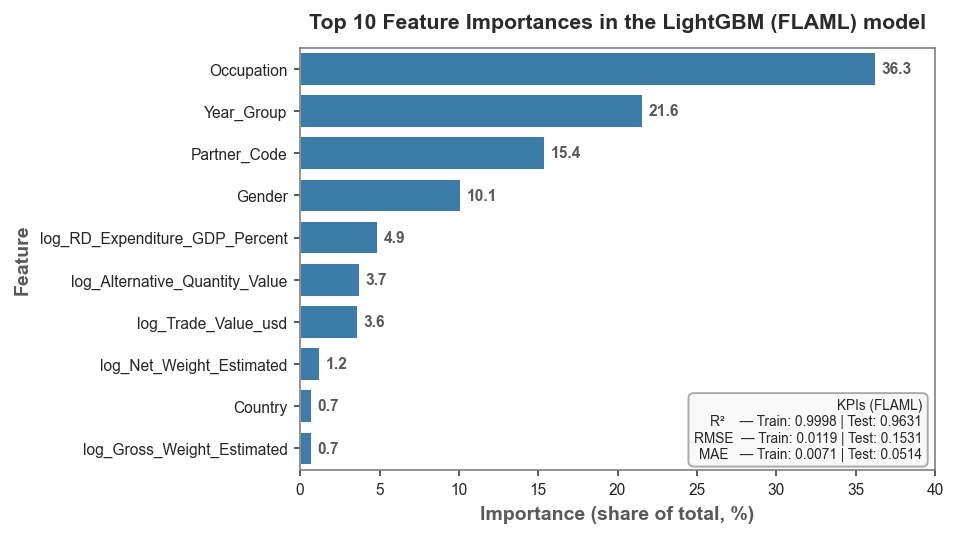

In [112]:
# ==========================================================
# FLAML LightGBM — Top 10 Feature Importances (share of total)
# ==========================================================

# 1) Access native LightGBM model from FLAML and pull importances
native_model = automl.model.model               # FLAML -> sklearn wrapper -> native LGBM
importances  = np.asarray(native_model.feature_importances_, dtype=float)
feature_names = np.asarray(X_train.columns)

# 2) Build importance table, compute % share, cumulative, rank
feat_df_flaml = (pd.DataFrame({"Feature": feature_names, "Importance": importances})
                .assign(Importance=lambda d: pd.to_numeric(d["Importance"], errors="coerce"))
                .dropna(subset=["Importance"])
                .sort_values("Importance", ascending=False, ignore_index=True))

total = feat_df_flaml["Importance"].sum() or 1.0
feat_df_flaml["SharePct"]    = 100 * feat_df_flaml["Importance"] / total
feat_df_flaml["CumSharePct"] = feat_df_flaml["SharePct"].cumsum()
feat_df_flaml["Rank"]        = np.arange(1, len(feat_df_flaml) + 1)

# 3) Plot (Top 10, descending)
TOP_N  = 10
plot_df = feat_df_flaml.head(TOP_N)

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(7, 4))

sns.barplot(data=plot_df, x="SharePct", y="Feature",
            color="#2C7FB8", ax=ax, orient="h")

# Compact ticks
ax.tick_params(axis='y', length =3, width = 1, labelsize=8, color = AXIS_TEXT_CLR)
ax.tick_params(axis='x', length =3, width = 1, labelsize=8, color = AXIS_TEXT_CLR)

# --- Customize figure (axes) edge colors and thickness ---
for spine in ax.spines.values():
    spine.set_edgecolor(FOOTNOTE_CLR)   # light grey color
    spine.set_linewidth(0.8)         # thinner border

ax.set_title(f"Top {TOP_N} Feature Importances in the LightGBM (FLAML) model",
            fontsize=11, pad=10, color = TITLE_CLR, weight = "bold")  
ax.set_xlabel("Importance (share of total, %)", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")
ax.set_ylabel("Feature", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")

# Percent labels at end of each bar
xmax = plot_df["SharePct"].max()
for p, pct in zip(ax.patches, plot_df["SharePct"].values):
    ax.text(p.get_width() + xmax * 0.01,
            p.get_y() + p.get_height() / 2,
            f"{pct:.1f}",
            va="center", ha="left", fontsize=8, color=AXIS_TEXT_CLR, weight = "bold")

# Build KPI text for the box
kpi_text = (
        "KPIs (FLAML)\n"
        f"R²    — Train: {r2_train_fl:.4f} | Test: {r2_test_fl:.4f}\n"
        f"RMSE  — Train: {rmse_train_fl:.4f} | Test: {rmse_test_fl:.4f}\n"
        f"MAE   — Train: {mae_train_fl:.4f} | Test: {mae_test_fl:.4f}"
    )

ax.text(0.98, 0.02, kpi_text,
            transform=ax.transAxes, ha="right", va="bottom",
            fontsize=7,
            bbox=dict(boxstyle="round,pad=0.4", fc="#f9f9f9", ec="#aaaaaa"))

# leave headroom + KPI space
ax.set_xlim(0, 40)

plt.tight_layout()
plt.show()

# 4) Save importance tables
feat_df_flaml.to_csv("flaml_best_model_lgb_feature_importances.csv", index=False)
feat_df_flaml.head(TOP_N).to_csv(f"flaml_best_model_lgb_feature_importances_top{TOP_N}.csv",
                                index=False)

In [113]:
feat_df_flaml

,Feature,Importance,SharePct,CumSharePct,Rank
0,Occupation,1728038.0,36.272914,36.272914,1
1,Year_Group,1029092.0,21.601473,57.874387,2
2,Partner_Code,735948.0,15.448143,73.322530,3
3,Gender,481521.0,10.107515,83.430045,4
4,log_RD_Expenditure_GDP_Percent,234293.0,4.917999,88.348044,5
5,log_Alternative_Quantity_Value,178329.0,3.743270,92.091314,6
6,log_Trade_Value_usd,173112.0,3.633761,95.725075,7
7,log_Net_Weight_Estimated,58484.0,1.227626,96.952701,8
8,Country,34828.0,0.731068,97.683769,9
9,log_Gross_Weight_Estimated,34431.0,0.722735,98.406504,10


Will be a dataframe created to save actual target values, model predictions, and residuals of best model LightGBM by FLAML for detailed evaluation, visualization, and comparison with alternative models

In [114]:
# Create DataFrame with Actual, Predicted, and Residuals
results_lgb_flaml = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_fl,
    'Residual': y_test - y_test_pred_fl
})

# Export the results to CSV file for analysis and reporting
results_lgb_flaml.to_csv('LGB_FL_test_predactresid.csv', index=False)

FLAML does not provide built-in tools for generating SHAP values or Partial Dependence Plots (PDP). In order to compute these model interpretability metrics externally, I need access to the preprocessed training data that was used for model fitting by FLAML itself. But it is not possible, due to that FLAML does not provide this access also.  To solve this, I will train FLAML on my already preprocessed dataset, so that I can later extract model explanations using the same feature set.

I ran **FLAML AutoML on the already preprocessed data** and obtained its best model. However, I deactivated this code afterward to save memory and ensure sufficient memory resources are available for running H2O AutoML later.

In [ ]:
# before preprocessed data

# X_train_proc = baseline_preprocessor.transform(X_train)
# X_test_proc = baseline_preprocessor.transform(X_test)

In [ ]:
# # Initialize another FLAML AutoML to build model with already preprocessed data
# automlL = AutoML(stateful=True)

# # Configure training
# automlL_settings = {
#     "time_budget": 10800,              # in seconds
#     "metric": 'r2',                   # target metric
#     "task": 'regression',
#     "log_file_name": "flamlL.log",
#     "verbose": 2
# }

# # Train
# automlL.fit(X_train=X_train_proc, y_train=y_train, **automlL_settings)


# # Predict
# y_train_pred_flL = automlL.predict(X_train_proc)
# y_test_pred_flL = automlL.predict(X_test_proc)

# # Train scores
# print("FLAML AutML with preprocessed input:")
# print("Train Scores")
# print("R²    :", r2_score(y_train, y_train_pred_flL))
# print("RMSE  :", mean_squared_error(y_train, y_train_pred_flL, squared=False))
# print("MAE   :", mean_absolute_error(y_train, y_train_pred_flL))

# # Test scores
# print("\nTest Scores")
# print("R²    :", r2_score(y_test, y_test_pred_flL))
# print("RMSE  :", mean_squared_error(y_test, y_test_pred_flL, squared=False))
# print("MAE   :", mean_absolute_error(y_test, y_test_pred_flL))

# # FLAML AutML with preprocessed input:
# # Train Scores
# # R²    : 0.9921761424856724
# # RMSE  : 0.06921359062012247
# # MAE   : 0.02344205743946831
# # 
# # Test Scores
# # R²    : 0.9485146940979972
# # RMSE  : 0.1788296140595735
# # MAE   : 0.05672104300814574




In [ ]:
# FLAML AutML with before preprocessed data input:
# Train Scores
# R²    : 0.9922
# RMSE  : 0.0692
# MAE   : 0.0234

# Test Scores
# R²    : 0.9485
# RMSE  : 0.1788
# MAE   : 0.0567

# FLAML AutML with internally preprocessed data:
# Train Scores
# R²    : 0.9998
# RMSE  : 0.0119
# MAE   : 0.0071
# 
# Test Scores
# R²    : 0.9631
# RMSE  : 0.1531
# MAE   : 0.0514

How it is seen, scores of the best model of 'FLAML AutML with before preprocessed data' input are lower than scores of 'FLAML AutML with internally preprocessed data'. So it will be further used model with internally preprocessed data(which provides best scores), what means it is not possible to get SHAP values and partial dependence Plots(PDP)

I will attempt to rebuild the **Random Forest** model based  on **feature importances by FLAML** with the goal of achieving even better performance.

In [131]:
# defining feature set for modeling for new Random forest model based on feature importances by FLAML
numeric_features_flaml = ['log_Trade_Value_usd', 'log_Alternative_Quantity_Value', 'log_RD_Expenditure_GDP_Percent'] 

target_encoded_feature = ['Occupation', 'Country']

onehot_categorical_features_flaml = ['Partner_Code', 'Gender',  'Year_Group'] 

# Binary flags
# binary_flag_features_flaml = ['Trade_Value_Is_Estimated','RD_Missing_Flag', 'AlternativeQty_Missing_Flag']

features_for_modeling_flaml = numeric_features_flaml + target_encoded_feature + onehot_categorical_features_flaml 

In [132]:
# Define X (features) and y (target) for modeling

X_fl = df_ml[features_for_modeling_flaml]
y_fl = df_ml['log_Employment_Growth']

# Splitting into train and test sets

X_train_fl, X_test_fl, y_train_fl, y_test_fl = train_test_split(X_fl, y_fl, test_size=0.2, random_state=42)  # splitting before target_encoding to avoid data leakage

In [133]:
# define preprocessor for Random Forest with FLAML feature importances

preprocessor_flaml = ColumnTransformer(transformers=[
    ('num', num_pip, numeric_features_flaml),                                                  
    ('onehot_cat', cat_pip, onehot_categorical_features_flaml),
    ('country_enc', target_pip, target_encoded_feature),
])

In [134]:
# pipeline for Random Forest 
rf_flaml = Pipeline([                           
    ('preprocessor', preprocessor_flaml),   
    ('model', RandomForestRegressor(random_state=42))
])

In [135]:
# Evaluate Random Forest with FLAML feature importances
name = 'Random Forest with FLAMLs features'
rf_flaml.fit(X_train_fl, y_train_fl)

y_train_pred_flaml = rf_flaml.predict(X_train_fl)
y_test_pred_flaml = rf_flaml.predict(X_test_fl)

# R²
r2_train_flaml = r2_score(y_train_fl, y_train_pred_flaml)
r2_test_flaml = r2_score(y_test_fl, y_test_pred_flaml)

# RMSE
rmse_train_flaml = mean_squared_error(y_train_fl, y_train_pred_flaml, squared=False)
rmse_test_flaml = mean_squared_error(y_test_fl, y_test_pred_flaml, squared=False)

# MAE
mae_train_flaml = mean_absolute_error(y_train_fl, y_train_pred_flaml)
mae_test_flaml = mean_absolute_error(y_test_fl, y_test_pred_flaml)

# Print output
print(f"{name}")
print(f"   R²    : Train = {r2_train_flaml:.4f}, Test = {r2_test_flaml:.4f}")
print(f"   RMSE  : Train = {rmse_train_flaml:.4f}, Test = {rmse_test_flaml:.4f}")
print(f"   MAE   : Train = {mae_train_flaml:.4f}, Test = {mae_test_flaml:.4f}\n")


Random Forest with FLAMLs features
   R²    : Train = 0.9933, Test = 0.9555
   RMSE  : Train = 0.0649, Test = 0.1681
   MAE   : Train = 0.0182, Test = 0.0476



Now **Random Forest with FLAMLs feature importances overwrote own best results**. Later will cross validation be done on it. 

I want to compare performance of LightGBM after dropping less-important features. **LightGBM** will be tried with **using FLAML feature importances**

In [141]:
# create pipeline for LightGBM based on feature importances by FLAML
lgb_flaml = Pipeline([                           # LGBM using hyperparameters by FLAML based on FLAML FI
    ('preprocessor', preprocessor_flaml),   
    ('model', LGBMRegressor(colsample_bytree=0.8595170413124158,
                learning_rate=0.03055307530885056, max_bin=1023,
                min_child_samples=8, n_estimators=17710, n_jobs=-1,
                num_leaves=270, reg_alpha=0.004764594150371958,
                reg_lambda=3.362276710396613, verbose=-1))])

In [142]:
# Evaluate LightGBM based on feature importances by FLAML
name = 'LGBM using FI by FLAML(dropped some feat.)'
lgb_flaml.fit(X_train_fl, y_train_fl)

y_train_pred_lgb_fl = lgb_flaml.predict(X_train_fl)
y_test_pred_lgb_fl = lgb_flaml.predict(X_test_fl)

# R²
r2_train_lgb_fl = r2_score(y_train_fl, y_train_pred_lgb_fl)
r2_test_lgb_fl = r2_score(y_test_fl, y_test_pred_lgb_fl)

# RMSE
rmse_train_lgb_fl = mean_squared_error(y_train_fl, y_train_pred_lgb_fl, squared=False)
rmse_test_lgb_fl = mean_squared_error(y_test_fl, y_test_pred_lgb_fl, squared=False)

# MAE
mae_train_lgb_fl = mean_absolute_error(y_train_fl, y_train_pred_lgb_fl)
mae_test_lgb_fl = mean_absolute_error(y_test_fl, y_test_pred_lgb_fl)

# Print output
print(f"{name}")
print(f"   R²    : Train = {r2_train_lgb_fl:.4f}, Test = {r2_test_lgb_fl:.4f}")
print(f"   RMSE  : Train = {rmse_train_lgb_fl:.4f}, Test = {rmse_test_lgb_fl:.4f}")
print(f"   MAE   : Train = {mae_train_lgb_fl:.4f}, Test = {mae_test_lgb_fl:.4f}\n")


LGBM using FI by FLAML(dropped some feat.)
   R²    : Train = 0.9987, Test = 0.9565
   RMSE  : Train = 0.0285, Test = 0.1661
   MAE   : Train = 0.0144, Test = 0.0609



In [ ]:
# FLAML AutML:
# Train Scores
# R²    : 0.9998
# RMSE  : 0.0119
# MAE   : 0.0071
# 
# Test Scores
# R²    : 0.9631
# RMSE  : 0.1531
# MAE   : 0.0514

# LGBM using FI by FLAML(dropped some feat.)
# R²    : Train = 0.9987, Test = 0.9565
# RMSE  : Train = 0.0285, Test = 0.1661
# MAE   : Train = 0.0144, Test = 0.0609

**LGMB built by FLAML with copmlete features_for_modeling gives higher results**. So, Best estimator: LGBMRegressor(colsample_bytree=0.8595170413124158,
              learning_rate=0.03055307530885056, max_bin=1023,
              min_child_samples=8, n_estimators=17710, n_jobs=-1,
              num_leaves=270, reg_alpha=0.004764594150371958,
              reg_lambda=3.362276710396613, verbose=-1)

To check how well the best variant of Random Forest -**Random Forest** model (**with FLAML’s selected features**) - generalizes to unseen data, **cross validation** will be done on it

In [143]:
# cross-validation for Random Forest model (with FLAML’s selected features)
cv_results_rflaml = cross_validate(
    rf_flaml,               # full pipeline
    X_train, y_train,              # raw features and target
    cv=5,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    },
    return_train_score=True
)

# Flip negatives for RMSE and MAE
rmse_train_fl = -cv_results_rflaml['train_rmse'].mean()
rmse_test_fl = -cv_results_rflaml['test_rmse'].mean()
mae_train_fl = -cv_results_rflaml['train_mae'].mean()
mae_test_fl = -cv_results_rflaml['test_mae'].mean()

r2_train_fl = cv_results_rflaml['train_r2'].mean()
r2_test_fl = cv_results_rflaml['test_r2'].mean()

# Print summary
print(f"Cross-Validated Scores for Random Forest with FI by FLAML:")
print(f"R²     : Train = {r2_train_fl:.4f}, Test = {r2_test_fl:.4f}")
print(f"RMSE   : Train = {rmse_train_fl:.4f}, Test = {rmse_test_fl:.4f}")
print(f"MAE    : Train = {mae_train_fl:.4f}, Test = {mae_test_fl:.4f}")



Cross-Validated Scores for Random Forest with FI by FLAML:
R²     : Train = 0.9928, Test = 0.9480
RMSE   : Train = 0.0675, Test = 0.1807
MAE    : Train = 0.0205, Test = 0.0547


In [ ]:
# This is the best variant of Random Forest and at the end it will be compared with LightGBM (best model from FLAML) and best model of H2O that will be found later. 

# Cross-Validated Scores for Random Forest with FI by FLAML:
# R²     : Train = 0.9928, Test = 0.9480
# RMSE   : Train = 0.0675, Test = 0.1807
# MAE    : Train = 0.0205, Test = 0.0547

Will be a dataframe created to save actual target values, model predictions, and residuals of best variant of random forest - Random Forest with FI by FLAML - for detailed evaluation, visualization, and comparison with alternative models

In [145]:

y_test_pred_rf_flaml = rf_flaml.predict(X_test)

# create Actual, Predicted and Residuals
results_rf_flaml = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_rf_flaml,
    'Residual': y_test - y_test_pred_rf_flaml
})

# export the results to csv for analysis and reporting
results_rf_flaml.to_csv('RandomForestFL_test_predactresid.csv', index=False)

**H2O AutoML** is included to my project to test another powerful AutoML approach alongside FLAML. It automatically tries multiple algorithms (like XGBoost, GBM, Stacked Ensembles) and extensive hyperparameter tuning, allowing me to explore if even better models can be found compared to previous methods.

In [146]:
# Start H2O cluster
h2o.init(max_mem_size="8G") 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 24+36-3646, mixed mode, sharing)
  Starting server from C:\Users\Cursist\anaconda3\envs\homl3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Cursist\AppData\Local\Temp\tmpb0m57rkh
  JVM stdout: C:\Users\Cursist\AppData\Local\Temp\tmpb0m57rkh\h2o_Cursist_started_from_python.out
  JVM stderr: C:\Users\Cursist\AppData\Local\Temp\tmpb0m57rkh\h2o_Cursist_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Brussels
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 year and 1 day
H2O_cluster_name:,H2O_from_python_Cursist_cemj38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.983 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [147]:
# Preparing features and target
X_h = df_ml[features_for_modeling].copy()
y_h = df_ml["log_Employment_Growth"].copy()

# Combine into one DataFrame
df_h2o = pd.concat([X_h, y_h], axis=1)

# Define target column
target = "log_Employment_Growth"
features = features_for_modeling

# Convert to H2OFrame
h2o_df = h2o.H2OFrame(df_h2o)

# Define categorical features
for col in X_h.select_dtypes(include="object").columns:
    h2o_df[col] = h2o_df[col].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [148]:
# split data into train, test
train, test = h2o_df.split_frame(ratios=[0.8], seed=42)

In [149]:
# model choices
aml = H2OAutoML(include_algos=["GBM", "GLM", "XGBoost", "DRF", "StackedEnsemble"], max_runtime_secs=10800, 
                nfolds=5, keep_cross_validation_predictions=True, sort_metric="R2", verbosity="info", seed=42)
# Train the AutoML model
aml.train(x=features, y=target, training_frame=train, leaderboard_frame=test)

AutoML progress: |
00:10:14.993: Project: AutoML_1_20251104_01014
00:10:14.995: Setting stopping tolerance adaptively based on the training frame: 0.00271056464408275
00:10:14.995: Build control seed: 42
00:10:14.996: training frame: Frame key: AutoML_1_20251104_01014_training_py_8_sid_93bf    cols: 17    rows: 136107  chunks: 13    size: 4161391  checksum: -6779103468629502768
00:10:14.997: validation frame: NULL
00:10:14.997: leaderboard frame: Frame key: py_9_sid_93bf    cols: 17    rows: 33878  chunks: 13    size: 1127359  checksum: -8794265207118172272
00:10:14.997: blending frame: NULL
00:10:14.998: response column: log_Employment_Growth
00:10:14.998: fold column: null
00:10:14.998: weights column: null
00:10:15.18: AutoML: XGBoost is not available; skipping it.
00:10:15.37: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [d

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20251104_01014_model_345


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    2                  2                           300102                 17           17           17            8833          8866          8849.5

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.4201122750617662
RMSE: 0.6481606861433098
MAE: 0.5101423340751293
RMSLE: 0.5270708288886918
Mean Residual Deviance: 0.4201122750617662

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.35120085779687854
RMSE: 0.5926220193317816
MAE: 0.46257462767961155
RMSLE: 0.4858725852434901
Mean Residual Deviance: 0.35120085779687854

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0          nan           nan           nan           nan           nan
loglikelihood           nan       0          nan           nan           nan           nan           nan
mae                     0.462574  0.0336742  0.461288      0.511834      0.461278      0.46178       0.416691
mean_residual_deviance  0.3512    0.0487409  0.347268      0.425072      0.349103      0.346644      0.287915
mse                     0.3512    0.0487409  0.347268      0.425072      0.349103      0.346644      0.287915
r2                      0.442184  0.0754772  0.448362      0.328686      0.445646      0.44688       0.541346
residual_deviance       0.3512    0.0487409  0.347268      0.425072      0.349103      0.346644      0.287915
rmse                    0.591492  0.0408858  0.589294      0.651975      0.590849      0.588765      0.536577
rmsle                   0.485196  0.028653   0.483711      0.526961      0.48382       0.485477      0.446011

Scoring History: 
    timestamp            duration           number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  -----------------  -----------------  ---------------  --------------  -------------------
    2025-11-04 02:53:35  9 min 59.376 sec   0                  0.793343         0.62714         0.629393
    2025-11-04 02:53:36  10 min  0.417 sec  2                  0.648161         0.510142        0.420112

Variable Importances: 
variable                        relative_importance    scaled_importance    percentage
------------------------------  ---------------------  -------------------  ------------
Gender                          88857.3                1                    0.592985
Occupation                      35620.4                0.400872             0.237711
Country                         22374.7                0.251805             0.149316
log_RD_Expenditure_GDP_Percent  1089.63                0.0122627            0.00727157
Partner_Code                    712.817                0.00802204           0.00475695
Year_Group                      441.402                0.00496754           0.00294568
log_Alternative_Quantity_Value  360.404                0.00405599           0.00240514
log_Trade_Value_usd             207.497                0.00233517           0.00138472
Commodity_Type                  56.1616                0.000632043          0.000374792
log_Gross_Weight_Estimated      36.7228                0.000413278          0.000245068
Alt_Quantity_Is_Estimated       35.6007                0.00040065           0.000237579
RD_Missing_Flag                 33.4111                0.000376009          0.000222968
Trade_Value_Is_Estima

In [ ]:
# Show top- and bottom-ranked models
lb = aml.leaderboard
print(lb.head(10))
print(lb.tail(10))

model_id                                            r2      rmse       mse       mae     rmsle    mean_residual_deviance
GBM_grid_1_AutoML_1_20251104_01014_model_345  0.329099  0.650241  0.422813  0.512101  0.528726                  0.422813
GBM_grid_1_AutoML_1_20251104_01014_model_167  0.418838  0.605192  0.366258  0.470555  0.49365                   0.366258
GLM_1_AutoML_1_20251104_01014                 0.599795  0.502211  0.252216  0.3363    0.411975                  0.252216
GBM_grid_1_AutoML_1_20251104_01014_model_20   0.731353  0.411468  0.169306  0.267777  0.337003                  0.169306
GBM_grid_1_AutoML_1_20251104_01014_model_65   0.775732  0.375949  0.141337  0.244609  0.308813                  0.141337
GBM_grid_1_AutoML_1_20251104_01014_model_118  0.779834  0.372495  0.138752  0.237413  0.298667                  0.138752
GBM_grid_1_AutoML_1_20251104_01014_model_32   0.790203  0.363617  0.132218  0.230622  0.289167                  0.132218
XRT_1_AutoML_1_20251104_01014   

In [152]:
leader = aml.leader
print(aml.leader.model_id) 

GBM_grid_1_AutoML_1_20251104_01014_model_345


In [153]:
print("Train Performance:")
perf_train = leader.model_performance(train)
print(perf_train)

print("Test Performance:")
perf_test = leader.model_performance(test)
print(perf_test)

Train Performance:
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.4201122749302245
RMSE: 0.6481606860418367
MAE: 0.5101423339016349
RMSLE: 0.527070828625141
Mean Residual Deviance: 0.4201122749302245
Test Performance:
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.42281273591532453
RMSE: 0.6502405215882232
MAE: 0.5121013344759647
RMSLE: 0.5287257180196967
Mean Residual Deviance: 0.42281273591532453


In [ ]:
# Evaluate the Leader Model (Test & Train)

# # On test set
perf_test = leader.model_performance(test)
print ("Scores on test data:")
print("R²:", perf_test.r2())
 
# # Optionally on train set
perf_train = leader.model_performance(train)
print ("Scores on training data:")
print("R²:", perf_train.r2())

Scores on test data:
R²: 0.32909873867374007
Scores on training data:
R²: 0.3325121888442861


The final aml.leader model is selected using H2O internal selection logic, and have been chosen not the best model as leader, but the worse model -
Gradient Boosting Machine - Model Key: GBM_grid_1_AutoML_1_20251104_01014_model_345.

Scores on test data:
R²: 0.32909873867374007
Scores on training data:
R²: 0.3325121888442861

However, tail() of leaderboard shows that GBM_grid_1_AutoML_1_20251104_01014_model_123  has better results.

Comparing R² scores of all models used by H2O will be defined the best model of H2O

In [155]:
# Find the best model by test R²
best_r2 = -1
best_model = None
best_test_perf = None
best_train_perf = None

for model_id in aml.leaderboard['model_id'].as_data_frame().values.flatten():
    model = h2o.get_model(model_id)
    perf_test = model.model_performance(test)
    r2 = perf_test.r2()

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_test_perf = perf_test
        best_train_perf = model.model_performance(train)  # Get training performance

# Print all metrics for the best model
print(f"\nBest model by test R²: {best_model.model_id}, R² = {best_r2:.4f}")

print("\nTrain Performance Metrics:")
print(f"R²:     {best_train_perf.r2():.4f}")
print(f"RMSE:   {best_train_perf.rmse():.4f}")
print(f"MAE:    {best_train_perf.mae():.4f}")
print(f"MSE:    {best_train_perf.mse():.4f}")
print(f"RMSLE:  {best_train_perf.rmsle():.4f}")
print(f"Mean Residual Deviance: {best_train_perf.mean_residual_deviance():.4f}")

print("\nTest Performance Metrics:")
print(f"R²:     {best_test_perf.r2():.4f}")
print(f"RMSE:   {best_test_perf.rmse():.4f}")
print(f"MAE:    {best_test_perf.mae():.4f}")
print(f"MSE:    {best_test_perf.mse():.4f}")
print(f"RMSLE:  {best_test_perf.rmsle():.4f}")
print(f"Mean Residual Deviance: {best_test_perf.mean_residual_deviance():.4f}")

c:\Users\Cursist\anaconda3\envs\homl3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



Best model by test R²: GBM_grid_1_AutoML_1_20251104_01014_model_123, R² = 0.9639

Train Performance Metrics:
R²:     0.9895
RMSE:   0.0812
MAE:    0.0344
MSE:    0.0066
RMSLE:  0.0532
Mean Residual Deviance: 0.0066

Test Performance Metrics:
R²:     0.9639
RMSE:   0.1508
MAE:    0.0476
MSE:    0.0227
RMSLE:  0.0775
Mean Residual Deviance: 0.0227


In [159]:
best_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20251104_01014_model_123


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    86                 86                          1.70248e+06            0            11           7.61628       1             1882          1105.14

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.006594899621414328
RMSE: 0.08120898731922674
MAE: 0.03441809501019094
RMSLE: 0.05318103341841213
Mean Residual Deviance: 0.006594899621414328

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.026590232037548914
RMSE: 0.1630651159431376
MAE: 0.04984326647899266
RMSLE: 0.08442120742241666
Mean Residual Deviance: 0.026590232037548914

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan        0            nan           nan           nan           nan           nan
loglikelihood           nan        0            nan           nan           nan           nan           nan
mae                     0.0498433  0.000600413  0.0494076     0.0502411     0.0506887     0.0492764     0.0496025
mean_residual_deviance  0.0265902  0.00176309   0.0237145     0.0277349     0.0282284     0.0263489     0.0269246
mse                     0.0265902  0.00176309   0.0237145     0.0277349     0.0282284     0.0263489     0.0269246
r2                      0.957754   0.00275965   0.962329      0.956198      0.955175      0.957957      0.957109
residual_deviance       0.0265902  0.00176309   0.0237145     0.0277349     0.0282284     0.0263489     0.0269246
rmse                    0.162991   0.00548583   0.153995      0.166538      0.168013      0.162323      0.164087
rmsle                   0.0844075  0.00170174   0.0824096     0.0848552     0.0868626     0.0832641     0.0846459

Scoring History: 
    timestamp            duration     number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  -----------  -----------------  ---------------  --------------  -------------------
    2025-11-04 02:04:36  1:40:25.376  0                  0.793343         0.62714         0.629393
    2025-11-04 02:04:37  1:40:26.155  5                  0.490278         0.380147        0.240372
    2025-11-04 02:04:38  1:40:26.928  10                 0.313603         0.234743        0.0983465
    2025-11-04 02:04:39  1:40:27.528  15                 0.213905         0.149672        0.0457553
    2025-11-04 02:04:39  1:40:28.119  20                 0.159455         0.101161        0.025426
    2025-11-04 02:04:40  1:40:28.760  25                 0.130718         0.0735381       0.0170873
    2025-11-04 02:04:40  1:40:29.340  30                 0.114227         0.0575162       0.0130478
    2025-11-04 02:04:41  1:40:29.911  35                 0.104448         0.048509        0.0109093
    2025-11-04 02:04:42  1:40:30.414  40                 0.0967416        0.0434467       0.00935894
    2025-11-04 02:04:42  1:40:30.688  45                 0.0941103        0.0415758       0.00885675
    2025-11-04 02:04:42  1:40:30.959  50                 0.0916793        0.0403362       0.00840509
    2025-11-04 02:04:43  1:40:31.432  55                 0.0869326        0.0380498       0.00755727
    2025-11-04 02:04:43  1:40:31.799  60                 0.0847187        0.036642        0.00717726
    2025-11-04 02:04:43  1:40:32.195  65                 0.0820363        0.0351175       0.00672995
    2025-11-04 02:04:44  1:40:32.

In [160]:
h2o.save_model(model=best_model, path="H2O_best_model", force=True)

'C:\\Users\\Cursist\\Documents\\Aynur\\DS_FinalProject\\Project_8_12\\H2O_best_model\\GBM_grid_1_AutoML_1_20251104_01014_model_123'

In [ ]:
# Best model by test R²: GBM_grid_1_AutoML_1_20251104_01014_model_123, R² = 0.9639

# Train Performance Metrics:
# R²:     0.9895
# RMSE:   0.0812
# MAE:    0.0344
# MSE:    0.0066
# RMSLE:  0.0532
# Mean Residual Deviance: 0.0066

# Test Performance Metrics:
# R²:     0.9639
# RMSE:   0.1508
# MAE:    0.0476
# MSE:    0.0227
# RMSLE:  0.0775
# Mean Residual Deviance: 0.0227

In [163]:
# get predictions of best model by H2O

preds = best_model.predict(test)
preds_df = preds.as_data_frame()
preds_df.to_csv("h2o_best_model_predictions.csv", index=False)

gbm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%


c:\Users\Cursist\anaconda3\envs\homl3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


To understand how the best model behaves on the test set, will be analyzed its prediction accuracy using actual vs predicted values, residual vs actual and  error distributions plots.

In [164]:
# Get predictions
y_pred_test_h2o = best_model.predict(test).as_data_frame().values.flatten()
y_actual_test_h2o = test[target].as_data_frame().values.flatten()

# Create a DataFrame for easier plotting
results_test_df_h2o = pd.DataFrame({
    'Actual': y_actual_test_h2o,
    'Predicted': y_pred_test_h2o,
    'Residual': y_actual_test_h2o - y_pred_test_h2o
})

output_path_test = "H2O_test_predactresid.csv"
results_test_df_h2o.to_csv(output_path_test, index=False)

print(f"✅ Test predictions saved successfully to '{output_path_test}'")
print(results_test_df_h2o.head())

gbm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%


c:\Users\Cursist\anaconda3\envs\homl3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\Cursist\anaconda3\envs\homl3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


✅ Test predictions saved successfully to 'H2O_test_predactresid.csv'
     Actual  Predicted  Residual
0 -0.111852  -0.076626 -0.035226
1 -0.122178  -0.104831 -0.017346
2 -0.101689  -0.107398  0.005709
3  0.262472   0.279749 -0.017277
4  1.207588   1.571878 -0.364290


In [ ]:
# TRAIN results
y_pred_train_h2o = best_model.predict(train).as_data_frame().values.flatten()
y_actual_train_h2o = train[target].as_data_frame().values.flatten()

# Create DataFrame with actual, predicted, and residuals of TRAIN results
results_train_df_h2o = pd.DataFrame({
    "Actual": y_actual_train_h2o,
    "Predicted": y_pred_train_h2o,
    'Residual': y_actual_train_h2o - y_pred_train_h2o
})

# Save to CSV
output_path_train = "H2O_train_predactresid.csv"
results_train_df_h2o.to_csv(output_path_train, index=False)

print(f"✅ Train predictions saved successfully to '{output_path_train}'")
print(results_train_df_h2o.head())

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\Cursist\anaconda3\envs\homl3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\Cursist\anaconda3\envs\homl3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


✅ Train predictions saved successfully to 'H2O_train_predactresid.csv'
     Actual  Predicted  Residual
0 -0.105422  -0.085356 -0.020066
1 -0.279833   0.037919 -0.317753
2 -0.026937  -0.059017  0.032080
3  0.027683   0.089065 -0.061383
4 -0.026937  -0.059663  0.032726


For better understanding of how the model makes predictions, identifying which features drive employment growth, h2o.explain() will be used that automatically generates comprehensive model interpretation report for the **best model  GBM_grid_1_AutoML_1_20251104_01014_model_123**. It provides visualizations such as variable importance, partial dependence plots, SHAP values, residual analysis, and other diagnostics. 

**Running PDP before crushed my laptop**, so i will get only Learning curve and Residual analysis

In [ ]:
# to get PDP, learning curve and residual analysis
# pdp_cols = [
#     "log_RD_Expenditure_GDP_Percent",
#     "log_Trade_Value_usd",
#     "log_Gross_Weight_Estimated",
# ]

# # You can show only the pieces you want, and restrict to your selected columns.
# h2o.explain(
#     best_model,              
#     frame=h2o_df,
#     columns=pdp_cols,              # PDP will be produced for these only
#     include_explanations=["residual_analysis", "learning_curve", "partial_dependence"]  # limit to these explanations only
# )

Using "h2o.explain(best_model, frame=h2o_df....)" produces model-level and frame-level outputs, which causes plots like the learning curve and residual analysis to appear twice. To avoid duplication, I attempted to run the explanations separately, but the code resulted in an error.

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

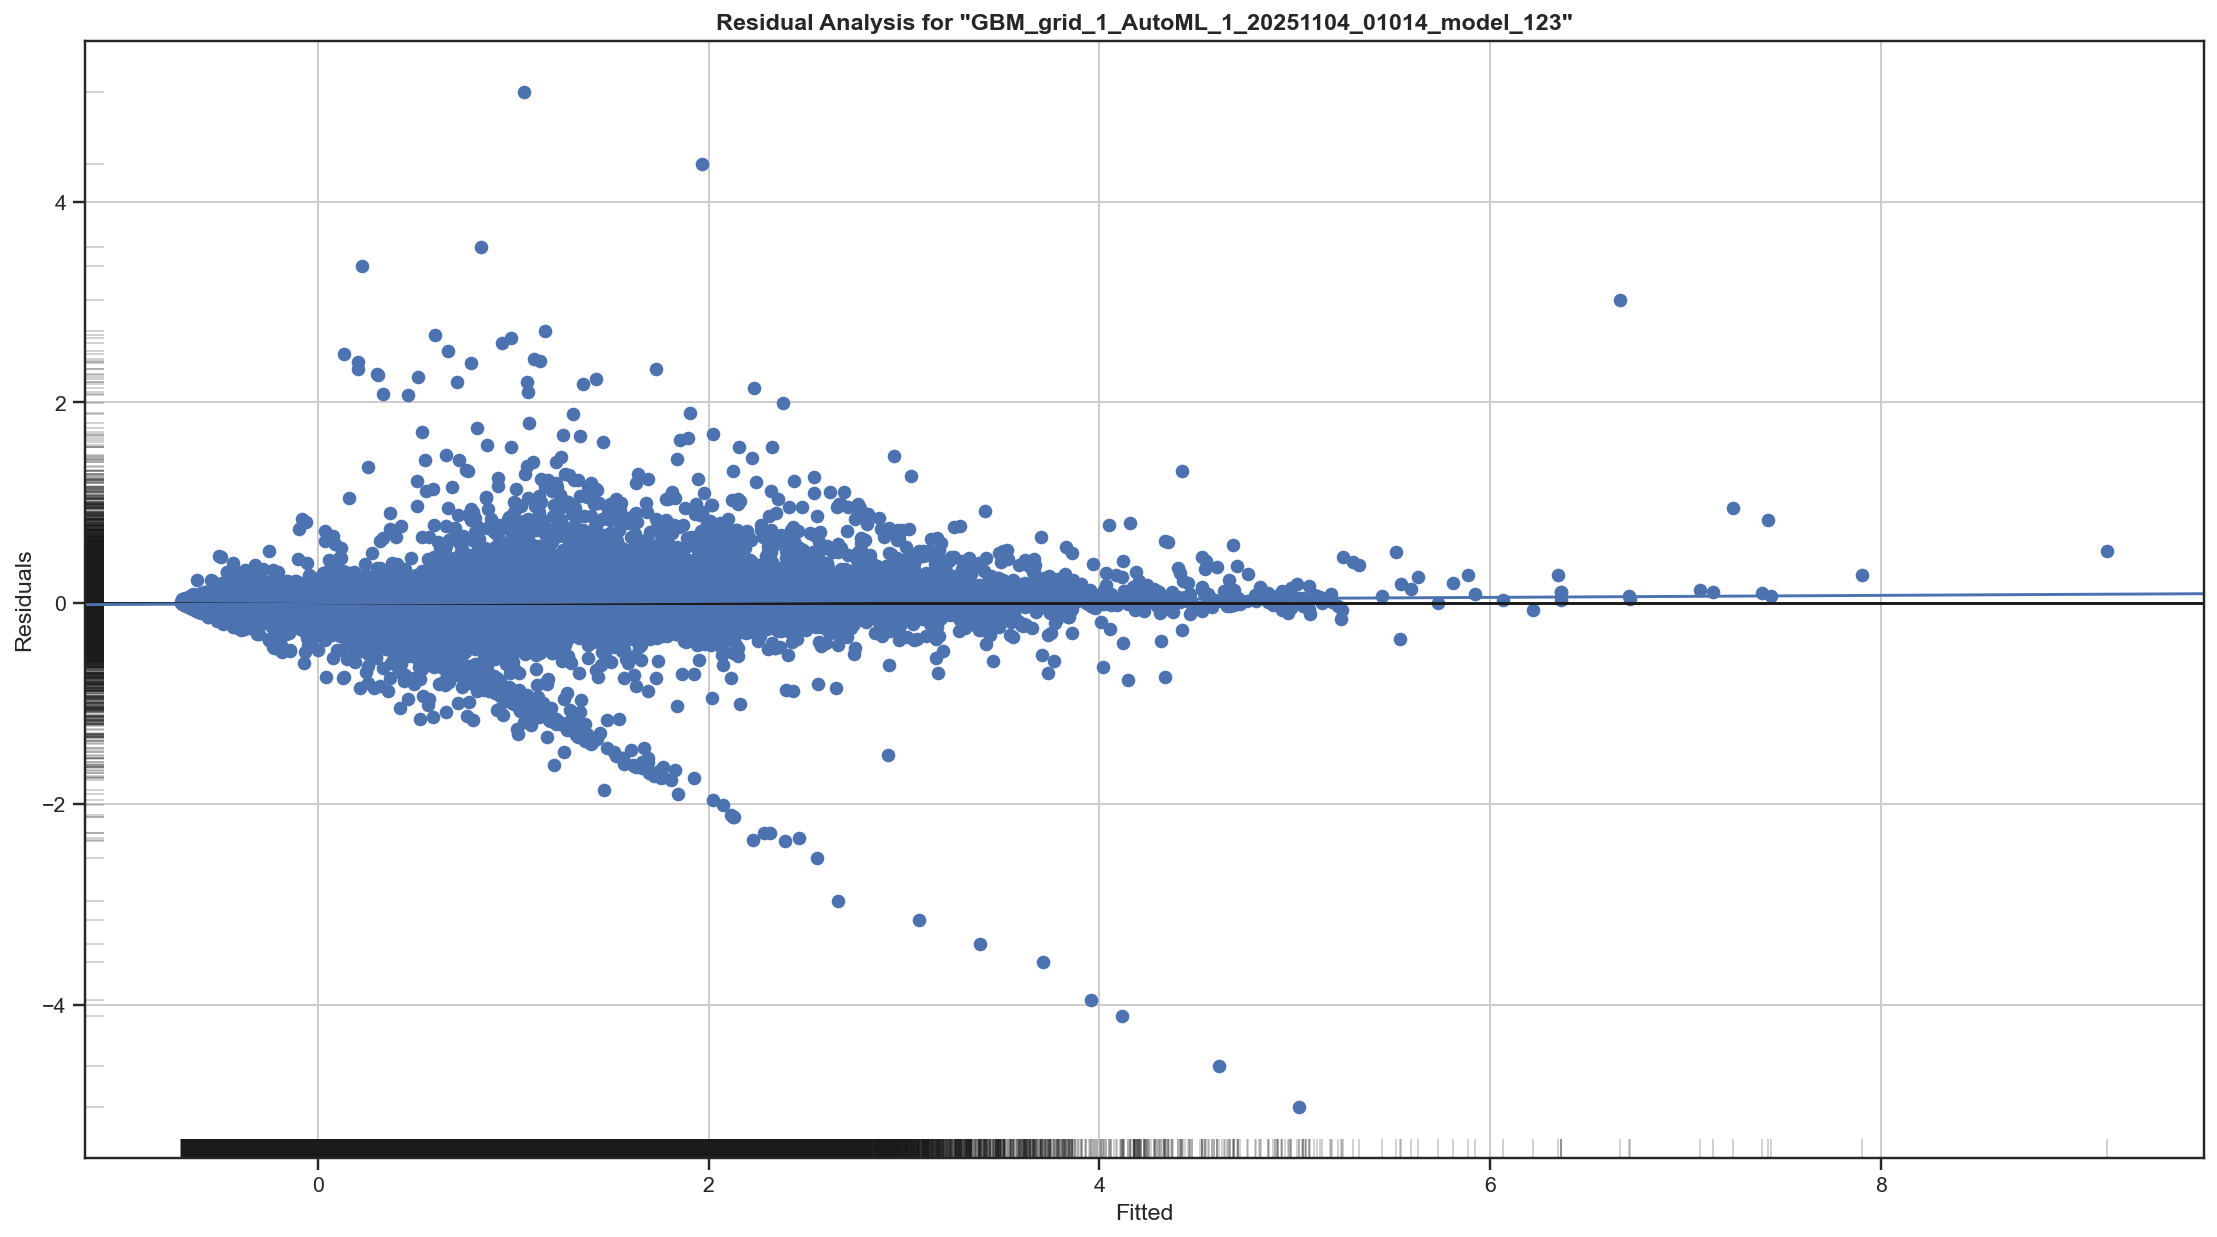

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

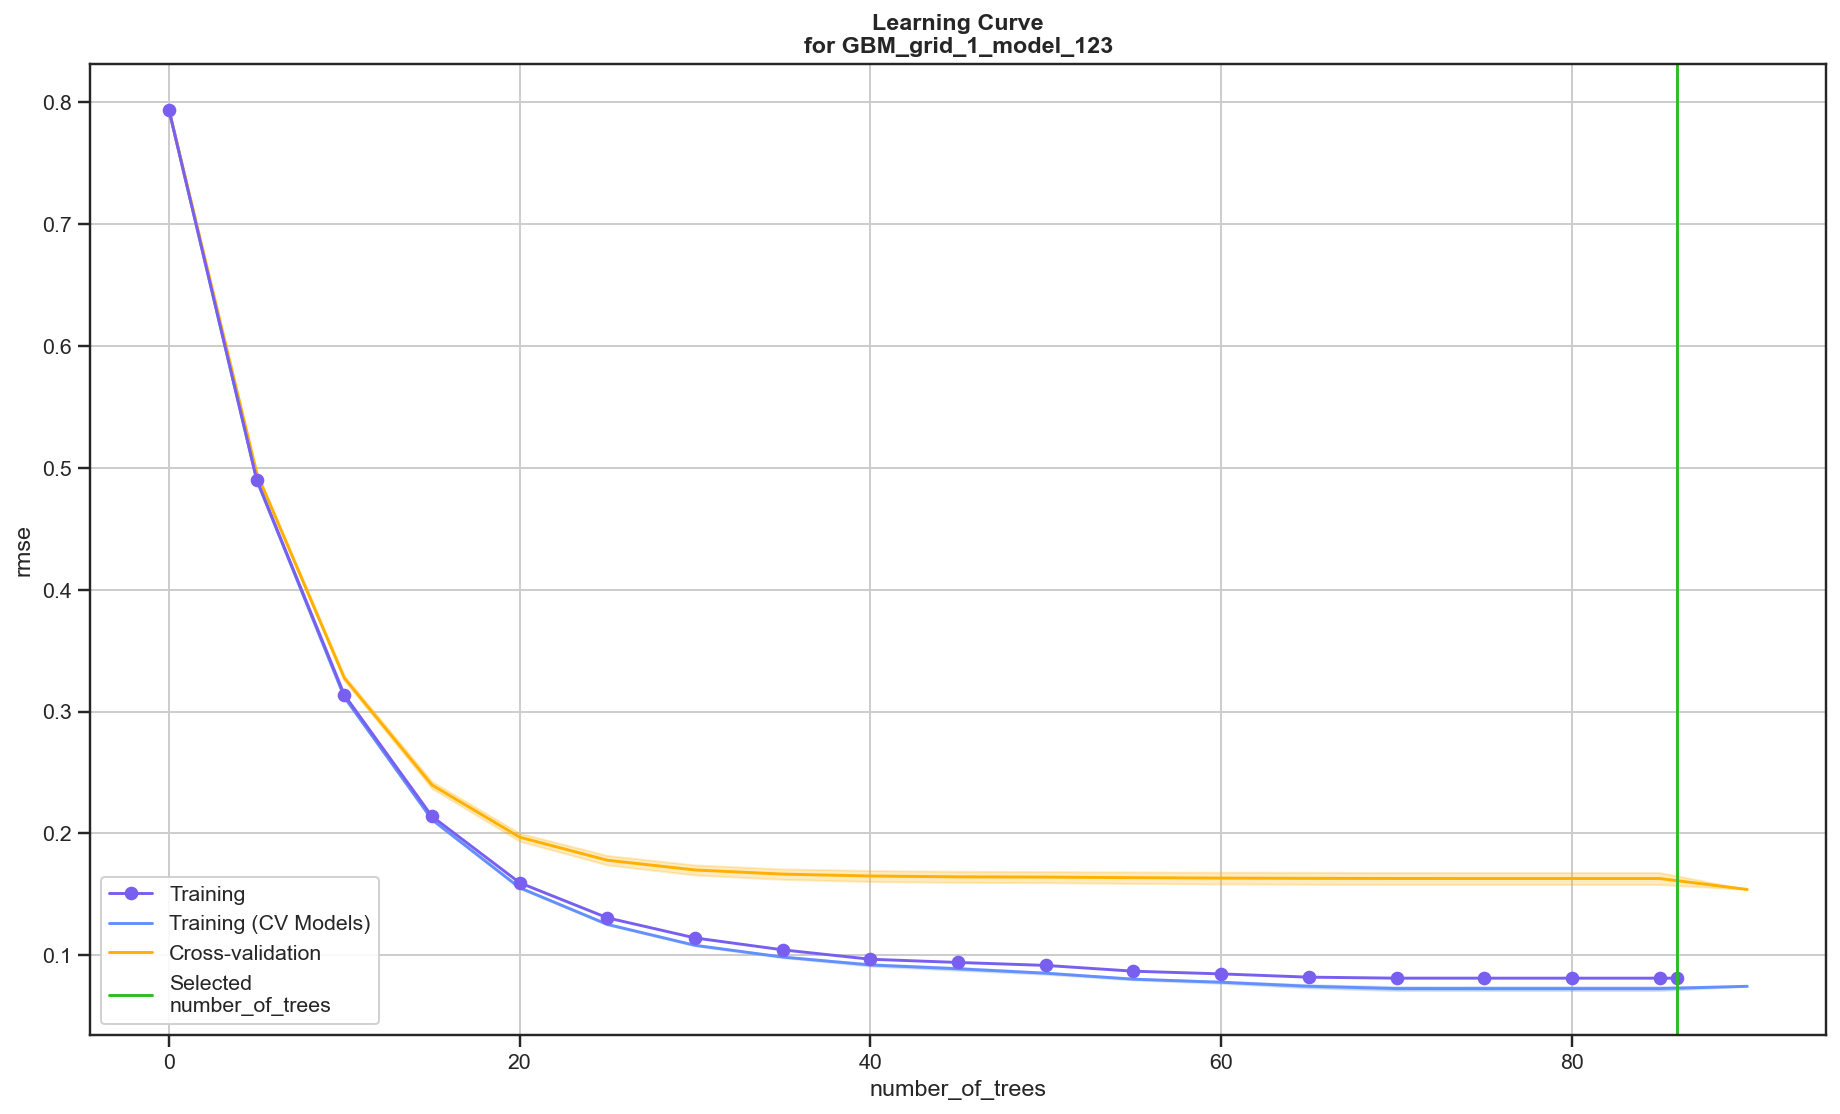

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

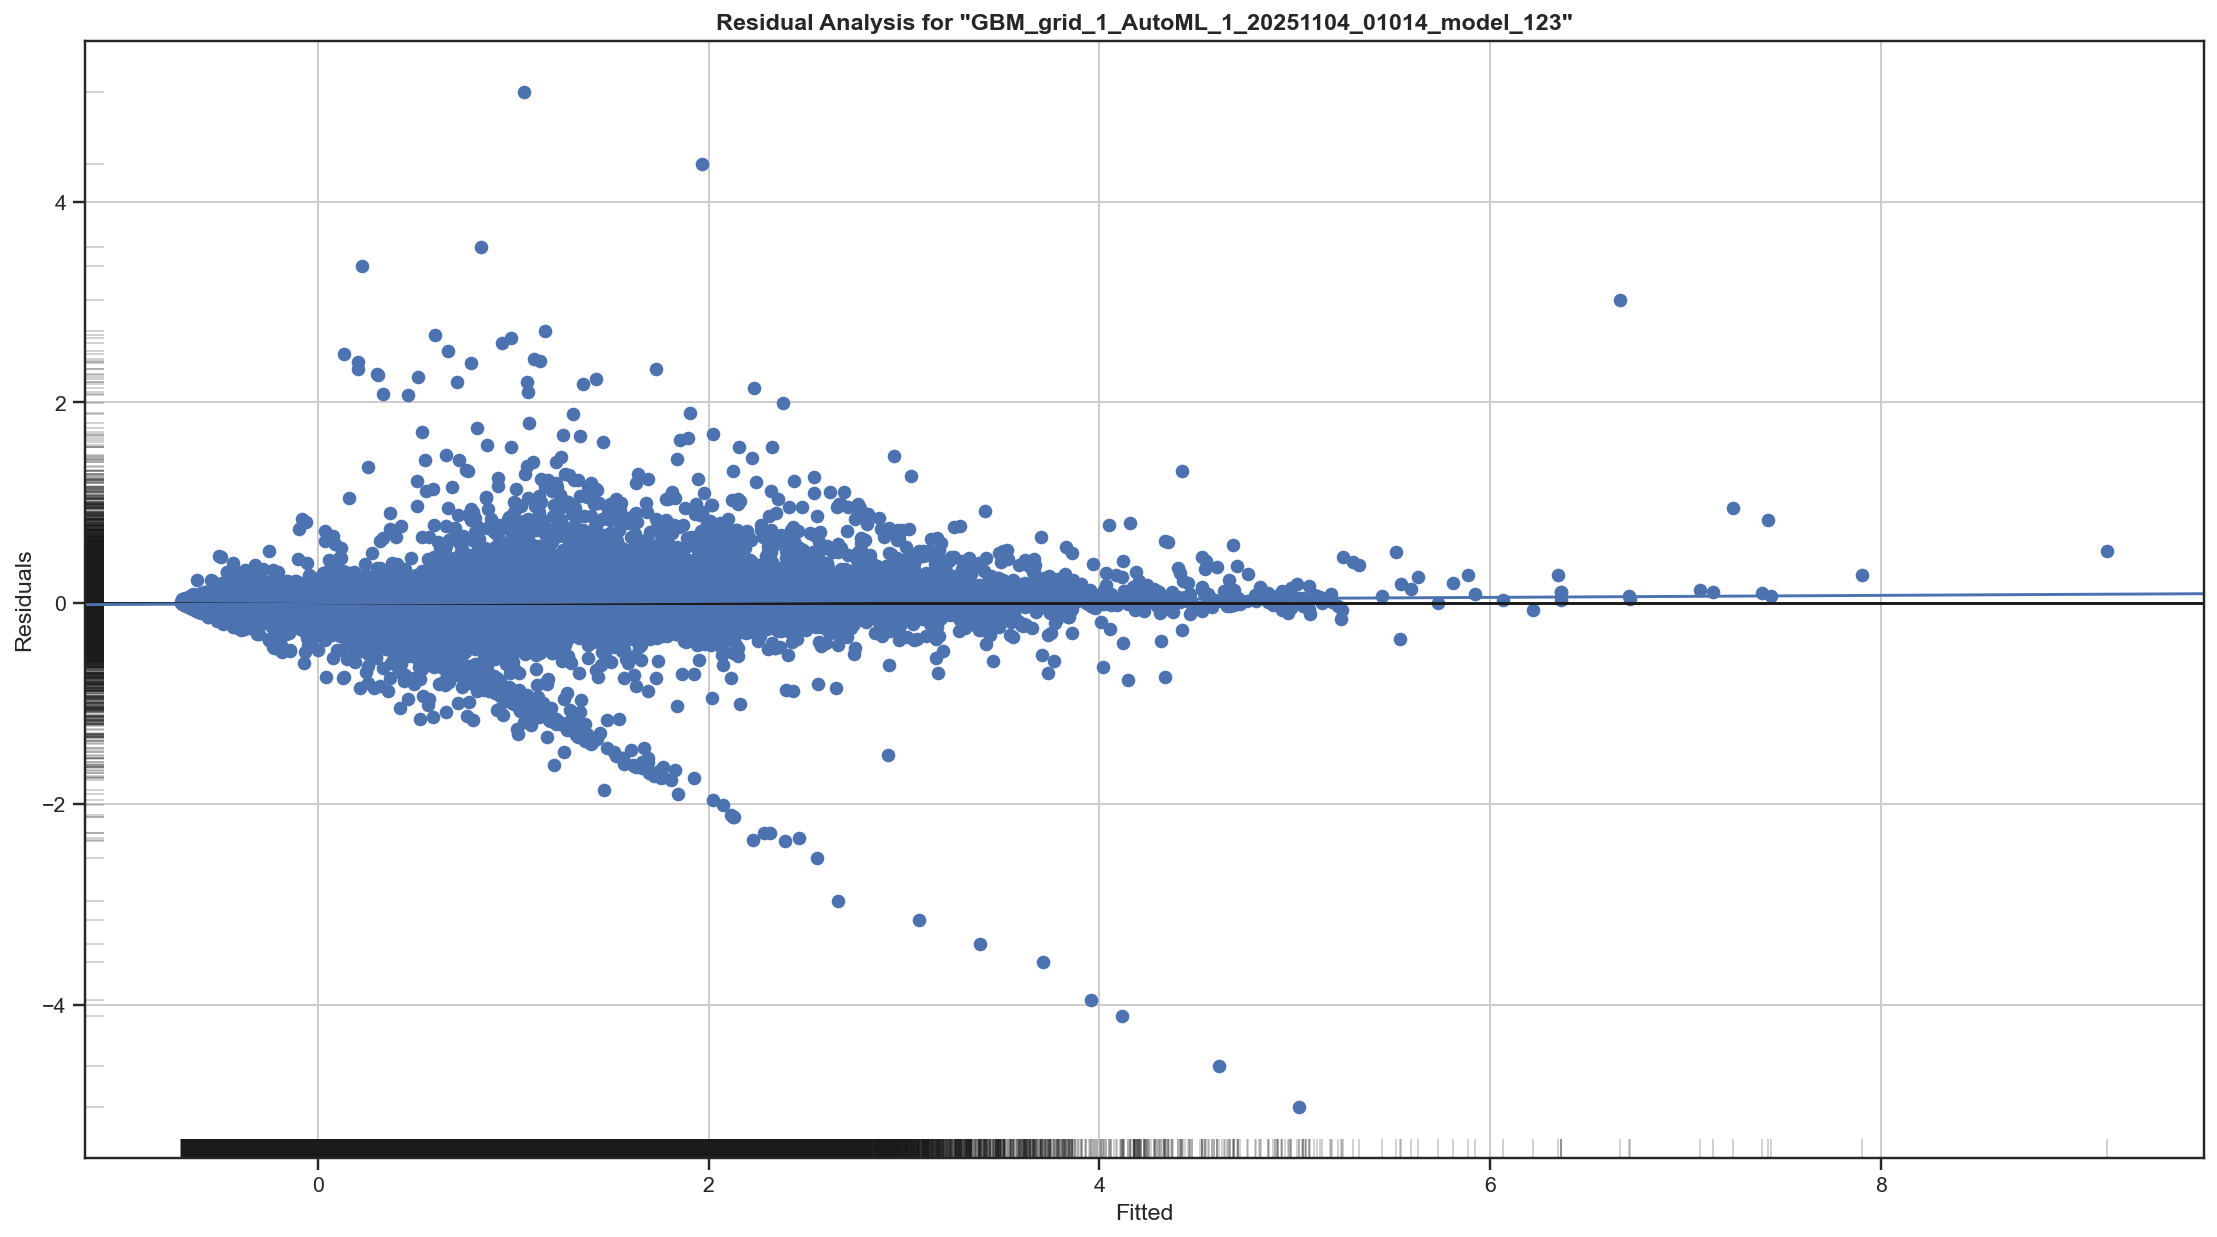

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

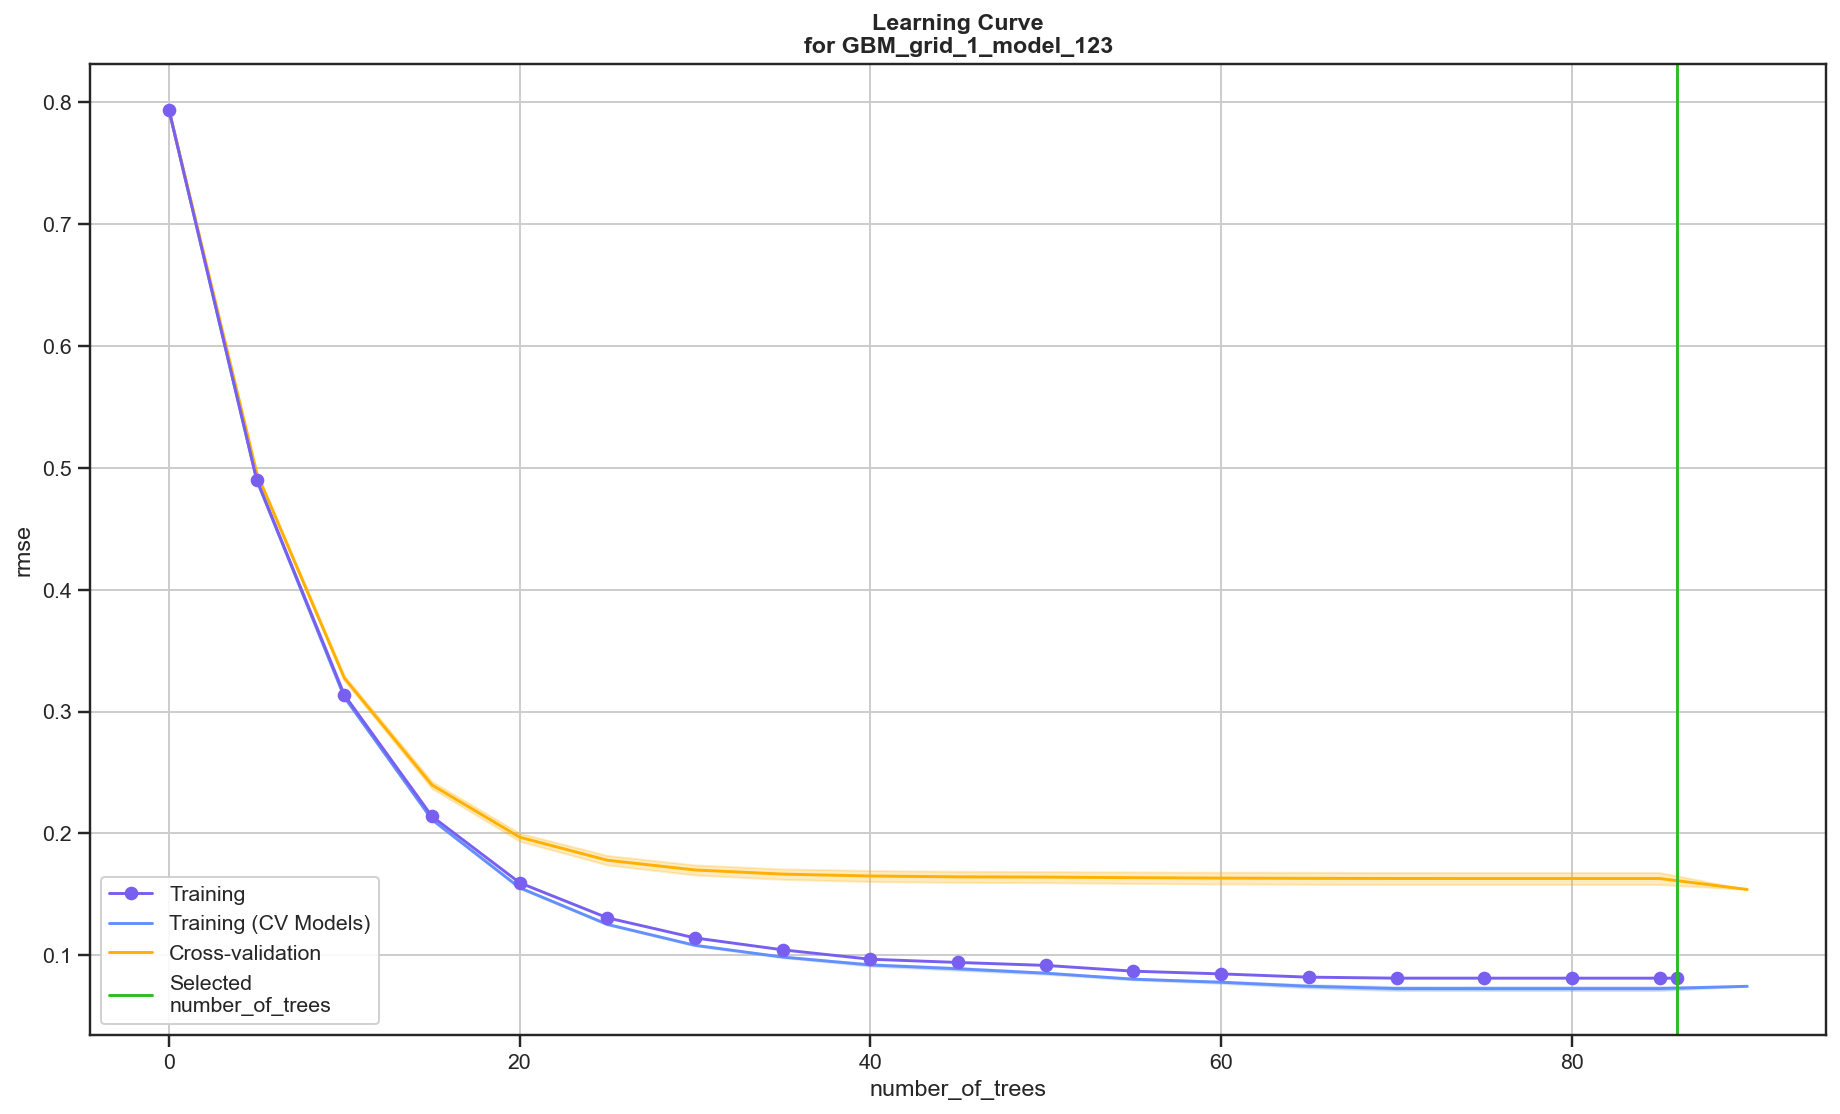

In [ ]:
# residuals on test (performance on data the model never saw)
h2o.explain(
    best_model,  
    frame=h2o_df,      
    include_explanations=["residual_analysis", "learning_curve"]
)

**Comparing 3 best models behavior on the test data to choose the best one**

In [ ]:
# Scores for Random Forest(with FLAML feature importance): 
# R²     : Train = 0.9933, Test = 0.9555
# RMSE   : Train = 0.0649, Test = 0.1681
# MAE    : Train = 0.0181, Test = 0.0476

In [ ]:
# Best model of FLAML AutML: 
# Best estimator: LGBMRegressor(colsample_bytree=0.8595170413124158,
#                 learning_rate=0.03055307530885056, max_bin=1023,
#                 min_child_samples=8, n_estimators=17710, n_jobs=-1,
#                 num_leaves=270, reg_alpha=0.004764594150371958,
#                 reg_lambda=3.362276710396613, verbose=-1)


# Train Scores
# R²    : 0.9998
# RMSE  : 0.0119
# MAE   : 0.0071

# Test Scores
# R²    : 0.9631
# RMSE  : 0.1531
# MAE   : 0.0514

In [ ]:
# Best model by test R²: GBM_grid_1_AutoML_1_20251104_01014_model_123

# Train Performance Metrics:
# R²:     0.9895
# RMSE:   0.0812
# MAE:    0.0344
# MSE:    0.0066
# RMSLE:  0.0532
# Mean Residual Deviance: 0.0066

# Test Performance Metrics:
# R²:     0.9639
# RMSE:   0.1508
# MAE:    0.0476
# MSE:    0.0227
# RMSLE:  0.0775
# Mean Residual Deviance: 0.0227

Comparing numerical perfomance of 3 best models , the conclusion is:

**GBM_grid_1_AutoML_1_20251104_01014_model_123 (H2O) is the final best model**.

In [ ]:
# get saved csv files with actuals, predictions and residuals

path_H2O_predict = "../Outputs/model_results/H2O_test_predactresid.csv"
path_H2O_predict_train = "../Outputs/model_results/H2O_train_predactresid.csv"
path_lgb_predict = "../Outputs/model_results/LGB_FL_test_predactresid.csv"
path_RF_fl_predict = "../Outputs/model_results/RandomForestFL_test_predactresid.csv"
df_h2o_predict = pd.read_csv(path_H2O_predict)
df_h2o_predict_train = pd.read_csv(path_H2O_predict_train)
df_lgb_predict = pd.read_csv(path_lgb_predict)
df_RF_fl_predict = pd.read_csv(path_RF_fl_predict)

To better understand which model perfoms most accurately, 3 best models will be compared side by side using Predicted vs Actual, Residual vs Actual and Residuals distribution plots. This allows to visually assess:

How closely predictions follow the actual values.

Whether any biases exist.

How well residuals are centered around zero, showing stability of predictions.

In [5]:
# =========================
# 0) SETUP (run once)
# =========================
sns.set_style("white")    
sns.set_context("talk")



# ---- helpers ----
def kpis(df):
    """R², RMSE, MAE, N for a dataframe with columns: Actual, Predicted."""
    y, yhat = df["Actual"].to_numpy(), df["Predicted"].to_numpy()
    r = yhat - y
    r2 = 1 - np.sum((y - yhat) ** 2) / np.sum((y - y.mean()) ** 2)
    rmse = np.sqrt(np.mean((y - yhat) ** 2))
    mae = np.mean(np.abs(r))
    return dict(r2=r2, rmse=rmse, mae=mae, n=len(df))

def bucket_colors(residuals, q_lo=0.05, q_hi=0.95):
    """Color each point by residual bucket (under / majority / over)."""
    lo, hi = np.quantile(residuals, [q_lo, q_hi])
    col_under = "#2563EB"  # blue   (underprediction)
    col_mid   = "#10B981"  # green  (majority)
    col_over  = "#DC2626"  # red    (overprediction)
    colors = np.where(residuals < lo, col_under,
            np.where(residuals > hi, col_over, col_mid))
    return colors, (lo, hi), (col_under, col_mid, col_over)

def prepare_aligned(models_raw):
    """
    Align rows across models once.
    models_raw: list of (name, df) where df has columns ['Actual', 'Predicted'].
    Returns:
            models: list of (name, df_aligned, kpis_dict)
            xy_min, xy_max for shared square axes
            r_abs for shared residual limits
    """
    # rows common to all dataframes
    common_idx = set(models_raw[0][1].index)
    for _, d in models_raw[1:]:
        common_idx &= set(d.index)
    common_idx = sorted(common_idx)

    aligned = []
    for name, d in models_raw:
        d = d.loc[common_idx].copy()
        m = np.isfinite(d["Actual"]) & np.isfinite(d["Predicted"])
        d = d[m]
        d["Residual"] = d["Predicted"] - d["Actual"]
        aligned.append((name, d, kpis(d)))

    # shared limits
    all_actual    = np.concatenate([d["Actual"].to_numpy()    for _, d, _ in aligned])
    all_predicted = np.concatenate([d["Predicted"].to_numpy() for _, d, _ in aligned])
    xy_min = float(np.nanmin([all_actual.min(), all_predicted.min()]))
    xy_max = float(np.nanmax([all_actual.max(), all_predicted.max()]))
    pad = 0.03 * (xy_max - xy_min)
    xy_min = max(0.0, xy_min - pad)   # KPIs are in pp → start at 0 if reasonable
    xy_max = xy_max + pad

    r_min = float(np.min([d["Residual"].min() for _, d, _ in aligned]))
    r_max = float(np.max([d["Residual"].max() for _, d, _ in aligned]))
    r_abs = max(abs(r_min), abs(r_max))

    return aligned, xy_min, xy_max, r_abs

def _legend_handles():
    return [
        Line2D([0],[0], marker='o', linestyle='', markersize=4, color='#2563EB',
                label='Underprediction'),
        Line2D([0],[0], marker='o', linestyle='', markersize=4, color='#10B981',
                label='Majority'),
        Line2D([0],[0], marker='o', linestyle='', markersize=4, color='#DC2626',
                label='Overprediction')
        ]

# =========================
# 1) PLOTTERS (re-usable)
# =========================
def plot_pred_vs_actual(models, xy_min, xy_max, title="Model Performance Comparison (Predicted vs Actual)",
                        show_grid=False):
    fig, axes = plt.subplots(1, 3, figsize=(19, 7.5), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=16, weight="bold", color = TITLE_CLR, y=0.93)

    for ax, (name, df, m) in zip(axes, models):
        colors, _, _ = bucket_colors(df["Residual"].to_numpy())
        ax.scatter(df["Actual"], df["Predicted"], s=12, alpha=0.6, c=colors, edgecolors='none')
        ax.plot([xy_min, xy_max], [xy_min, xy_max], ls='--', lw=1.2, color="gray")

        ax.set_xlim(xy_min, xy_max)
        ax.set_ylim(xy_min, xy_max)
        ax.tick_params(axis='both', which='both', length=5, width=1, color='black', labelsize=14)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(name, fontsize=14, pad=10, color = SUBTITLE_CLR,  weight = "semibold")
        ax.set_ylabel("Predicted", fontsize=14, color = AXIS_TEXT_CLR, weight = "semibold") if ax is axes[0] else None
        ax.set_xlabel("Actual", fontsize=14, color = AXIS_TEXT_CLR, weight = "semibold")
        ax.text(0.02, 0.98,
                f"R² {m['r2']:.4f} | RMSE {m['rmse']:.4f} | MAE {m['mae']:.4f} | N {m['n']:,}",
                transform=ax.transAxes, ha="left", va="top",
                fontsize=13, color="#333333",
                bbox=dict(boxstyle="round,pad=0.25", fc="#F9FAFB", ec="#E5E7EB"))
        if show_grid:
            ax.grid(alpha=0.2)

    axes[-1].legend(handles=_legend_handles(), frameon=True, fontsize=10, loc="upper left", bbox_to_anchor=(0.02, 0.93))

    n_common = models[0][2]['n']
    foot = (f"Notes: Colors indicate residual quantiles per model — underprediction = lowest 5%, "
            f"overprediction = highest 5%, majority = middle 90%\n"
             f"         • All panels use the same {n_common:,} rows and identical axes for fair comparison.")
    plt.figtext(0.07, -0.07, foot, ha="left", va="bottom", fontsize=14, color=FOOTNOTE_CLR, linespacing = 1.3)
    plt.tight_layout(rect=[0, 0.04, 1, 0.95])
    plt.show()

def plot_resid_vs_actual(models, xy_min, xy_max, r_abs,
                        title="Residuals vs Actual (by model)", show_grid=False):
    fig, axes = plt.subplots(1, 3, figsize=(19, 7.5), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=18, weight="bold", y=0.92)

    for ax, (name, df, m) in zip(axes, models):
        colors, _, _ = bucket_colors(df["Residual"].to_numpy())
        ax.scatter(df["Actual"], df["Residual"], s=12, alpha=0.6, c=colors, edgecolors='none')
        ax.axhline(0, color="gray", ls="--", lw=1.2)

        ax.set_xlim(xy_min, xy_max)
        ax.set_ylim(-r_abs, r_abs)
        ax.tick_params(axis='both', which='both', length=5, width=1, color='black', labelsize=14)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_title(name, fontsize=14, pad=10, color = SUBTITLE_CLR, weight = "semibold")
        ax.set_ylabel("Residual", fontsize=16, color = AXIS_TEXT_CLR, weight = "semibold") if ax is axes[0] else None
        ax.set_xlabel("Actual", fontsize=16, color = AXIS_TEXT_CLR, weight = "semibold")
        ax.text(0.02, 0.98,
                f"R² {m['r2']:.4f} | RMSE {m['rmse']:.4f} | MAE {m['mae']:.4f} | N {m['n']:,}",
                transform=ax.transAxes, ha="left", va="top",
                fontsize=13, color="#333333",
                bbox=dict(boxstyle="round,pad=0.25", fc="#F9FAFB", ec="#E5E7EB"))
        if show_grid:
            ax.grid(alpha=0.2)

    axes[-1].legend(handles=_legend_handles(), frameon=True, fontsize=10, 
                    loc="lower right", bbox_to_anchor=(1, 0.77))

    n_common = models[0][2]['n']
    foot = (f"Notes: Colors indicate residual quantiles per model — underprediction = lowest 5%, "
            "overprediction = highest 5%, majority = middle 90%.\n"
            f"         • Same rows across models ({n_common:,}). Residual = Predicted − Actual. Dashed line marks zero-residual.")
    plt.figtext(0.07, -0.03, foot, ha="left", va="bottom", fontsize=14, color=FOOTNOTE_CLR, linespacing = 1.3)
    plt.tight_layout(rect=[0, 0.04, 1, 0.95])

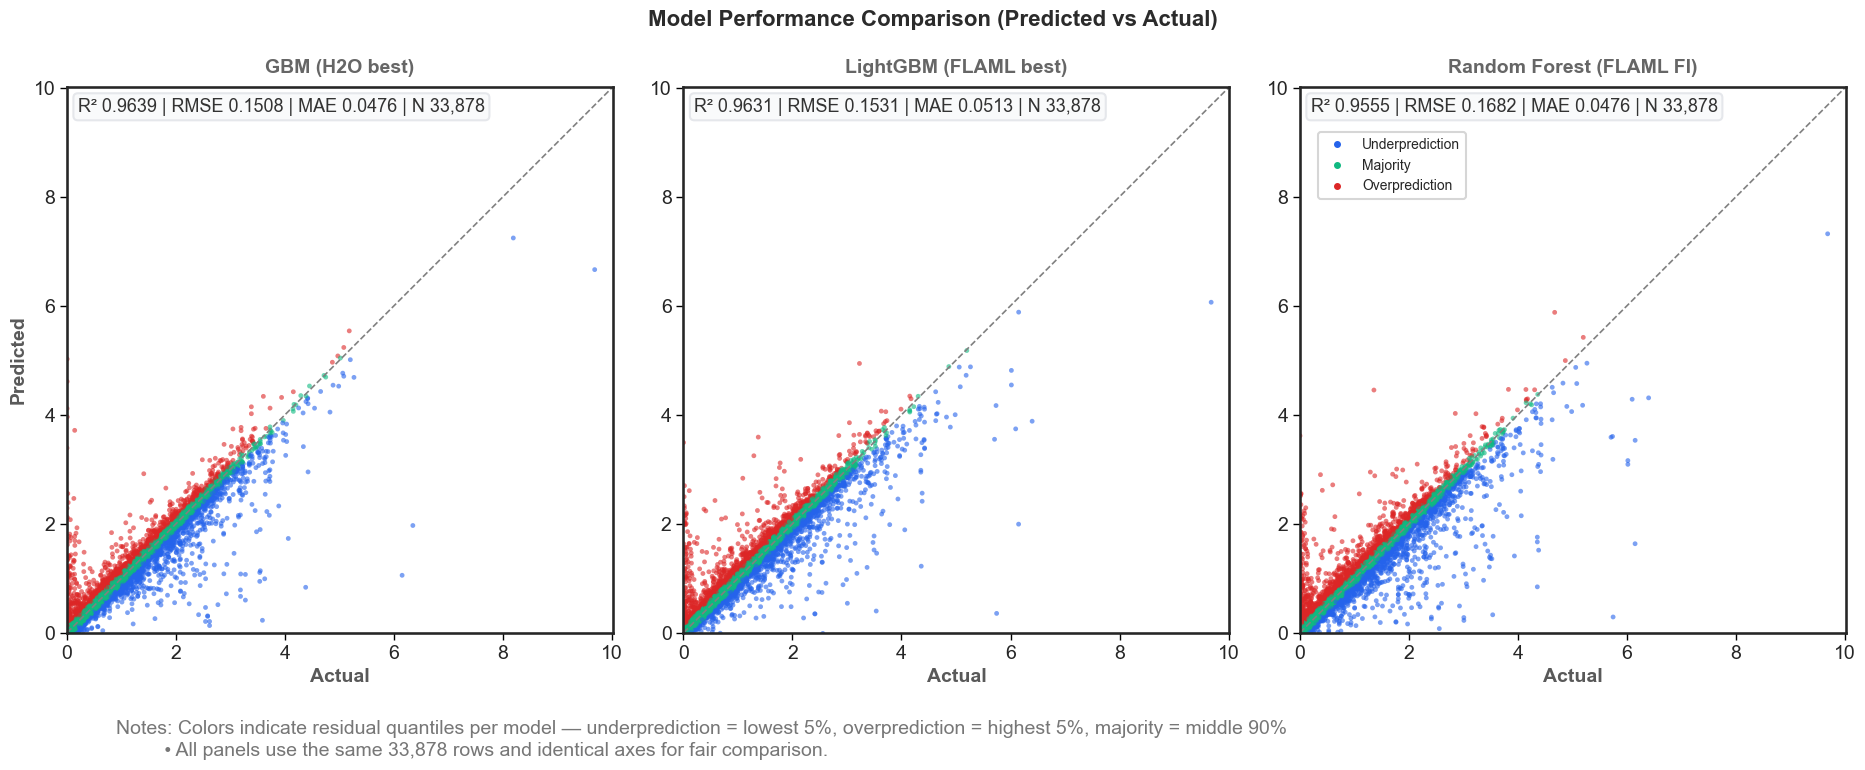

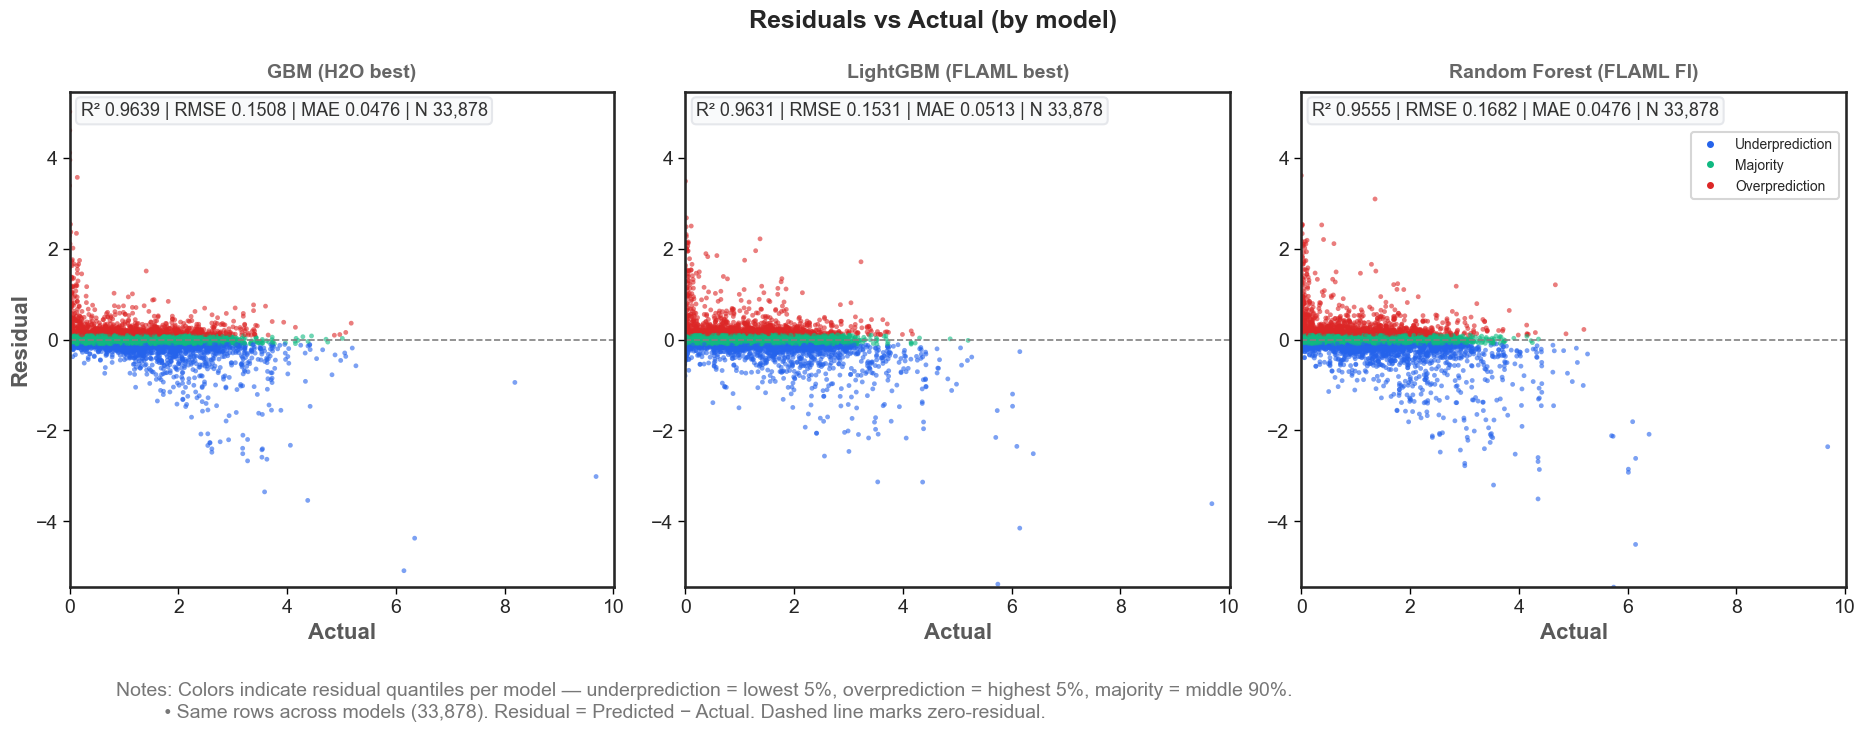

In [6]:
# Your three input dataframes that already contain columns: ['Actual', 'Predicted']
models_raw = [
    ("GBM (H2O best)",    df_h2o_predict),
    ("LightGBM (FLAML best)",    df_lgb_predict),
    ("Random Forest (FLAML FI)", df_RF_fl_predict),
]

# Align once + compute shared limits
models, xy_min, xy_max, r_abs = prepare_aligned(models_raw)

# 1) Predicted vs Actual (no grid)
plot_pred_vs_actual(models, xy_min, xy_max, show_grid=False)

# 2) Residual vs Actual (same style & colors, no grid)
plot_resid_vs_actual(models, xy_min, xy_max, r_abs, show_grid=False)


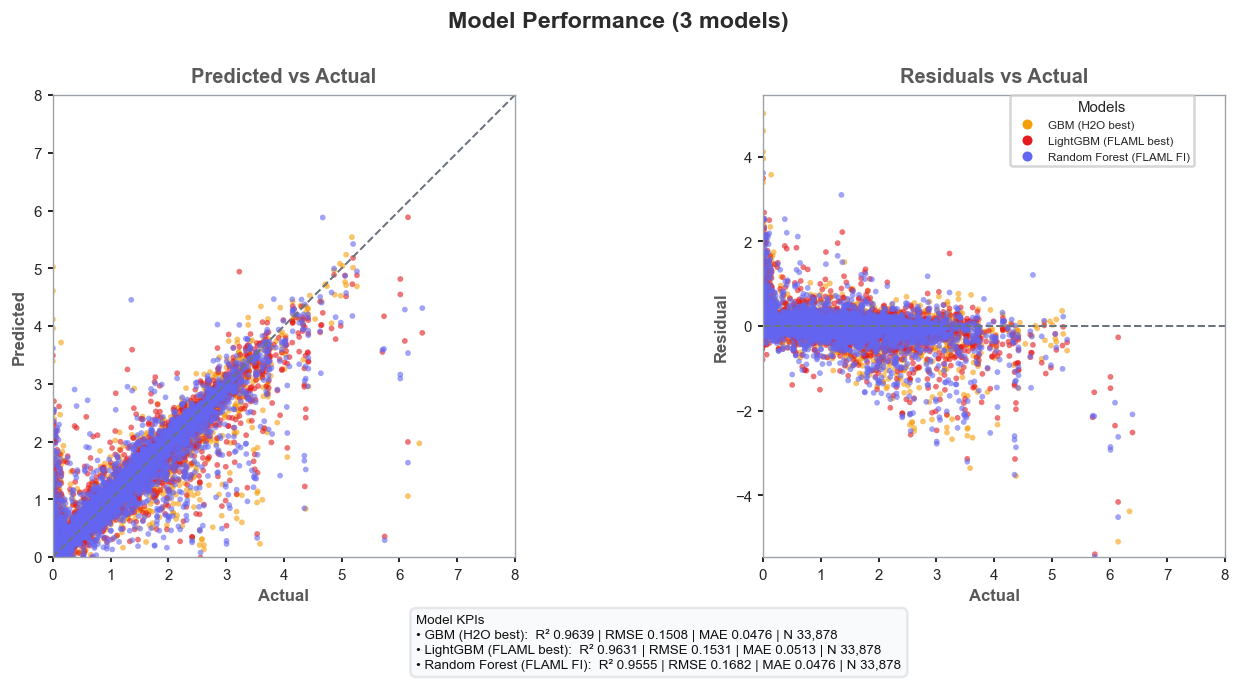

In [7]:
# --- align & limits from your helper ---
models, xy_min, xy_max, r_abs = prepare_aligned(models_raw)

# Force x-axis to 0..8 pp exactly
X_MIN, X_MAX = 0.0, 8.0
xy_min = X_MIN
xy_max = X_MAX

# consistent, color-blind friendly colors
model_colors = ["#F59E0B", "#e41a1c", "#6366F1"]  # teal, amber, indigo

# ---------------- Figure & layout ----------------
# Add a little extra top margin for the two info boxes; they sit **above** the axes,
# so they won't compress/squash the subplot
fig = plt.figure(figsize=(14, 5), dpi = 120, constrained_layout = False)
gs  = GridSpec(nrows=1, ncols=2, figure=fig, width_ratios=[1, 1], wspace=0.20)

ax_pa = fig.add_subplot(gs[0, 0])  # Predicted vs Actual
ax_ra = fig.add_subplot(gs[0, 1])  # Residuals vs Actual

# Same panel shapes
ax_pa.set_box_aspect(1.0)
ax_ra.set_box_aspect(1.0)
ax_pa.tick_params(axis='both', which='both', length=3, width=1, color='black')
ax_pa.xaxis.set_ticks_position('bottom')
ax_pa.yaxis.set_ticks_position('left')
ax_ra.tick_params(axis='both', which='both', length=3, width=1, color='black')
ax_ra.xaxis.set_ticks_position('bottom')
ax_ra.yaxis.set_ticks_position('left')


# Title
fig.suptitle("Model Performance (3 models)", fontsize=14, color = TITLE_CLR, weight="bold", y=1.02)

# Subtle spines
for ax in (ax_pa, ax_ra):
    for s in ax.spines.values():
        s.set_linewidth(0.8)
        s.set_color("#9AA0A6")
    ax.grid(False)
# ---------------- LEFT: Predicted vs Actual (true 1:1) ----------------
for (name, df, _), c in zip(models, model_colors):
    ax_pa.scatter(df["Actual"], df["Predicted"], s=12, alpha=0.60, c=c, edgecolors="none")

ax_pa.plot([xy_min, xy_max], [xy_min, xy_max], ls="--", lw=1.2, color="#6B7280")
ax_pa.set_xlim(xy_min, xy_max)
ax_pa.set_ylim(xy_min, xy_max)
# ax_pa.tick_params(axis='both', which='both', length=3, width=1, color='black')
# ax_pa.xaxis.set_ticks_position('bottom')
# ax_pa.yaxis.set_ticks_position('left')
ax_pa.set_aspect("equal", adjustable="box")
ax_pa.set_title("Predicted vs Actual", fontsize=12, color = AXIS_TEXT_CLR, weight = "semibold", pad=8)
ax_pa.set_xlabel("Actual", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")
ax_pa.set_ylabel("Predicted", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")
ax_pa.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=9))  # ticks at 0..8
ax_pa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=9))
ax_pa.tick_params(length = 3, labelsize=9)

# ---------------- RIGHT: Residuals vs Actual ----------------
for (name, df, _), c in zip(models, model_colors):
    ax_ra.scatter(df["Actual"], df["Residual"], s=12, alpha=0.60, c=c, edgecolors="none")

ax_ra.axhline(0, color="#6B7280", ls="--", lw=1.2)
ax_ra.set_xlim(xy_min, xy_max)
ax_ra.set_ylim(-r_abs, r_abs)
# ax_ra.tick_params(axis='both', which='both', length=3, width=1, color='black')
# ax_pa.xaxis.set_ticks_position('bottom')
# ax_pa.yaxis.set_ticks_position('left')
ax_ra.set_title("Residuals vs Actual", fontsize=12, color = AXIS_TEXT_CLR, weight = "semibold", pad=8)
ax_ra.set_xlabel("Actual", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")
ax_ra.set_ylabel("Residual", fontsize=10, color = AXIS_TEXT_CLR, weight = "semibold")
ax_ra.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=9))  # ticks at 0..8
ax_ra.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax_ra.tick_params(length = 3 ,labelsize=9)

# ---------------- KPI box (top center-right under title) ----------------
kpi_lines = [
    f"• {name}:  R² {m['r2']:.4f} | RMSE {m['rmse']:.4f} | MAE {m['mae']:.4f} | N {m['n']:,}"
    for (name, _, m) in models
]
fig.text(
    0.38, 0.015, "Model KPIs\n" + "\n".join(kpi_lines),
    ha="left", va="top", fontsize=8, color="#111",
    bbox=dict(boxstyle="round,pad=0.45", fc="#F9FAFB", ec="#E5E7EB")
)

# ---------------- Models legend (to the right of the KPI box) ----------------
handles = [Line2D([0],[0], marker='o', linestyle='', markersize=5, color=c, label=name)
        for (name, _, _), c in zip(models, model_colors)]
leg = fig.legend(handles=handles, title="Models", frameon=True, fontsize=7,
                loc="upper right", bbox_to_anchor=(0.843, 0.88), borderaxespad=0)
leg.get_title().set_fontsize(9)

plt.tight_layout(rect=[0.04, 0.06, 0.98, 0.90])
plt.show()

Because three models are evaluated on the same rows (same N) and already using the same bins across panels, histograms with counts on a log y-axis for Row 2 is the most intuitive for non-technical readers (“how many cases are out in the tails?”), while still revealing tail behavior.

Row 1: stat="density" → shows shape and spread

Row 2: stat="count" + log y-scale → reveals tail frequencies and magnitude differences

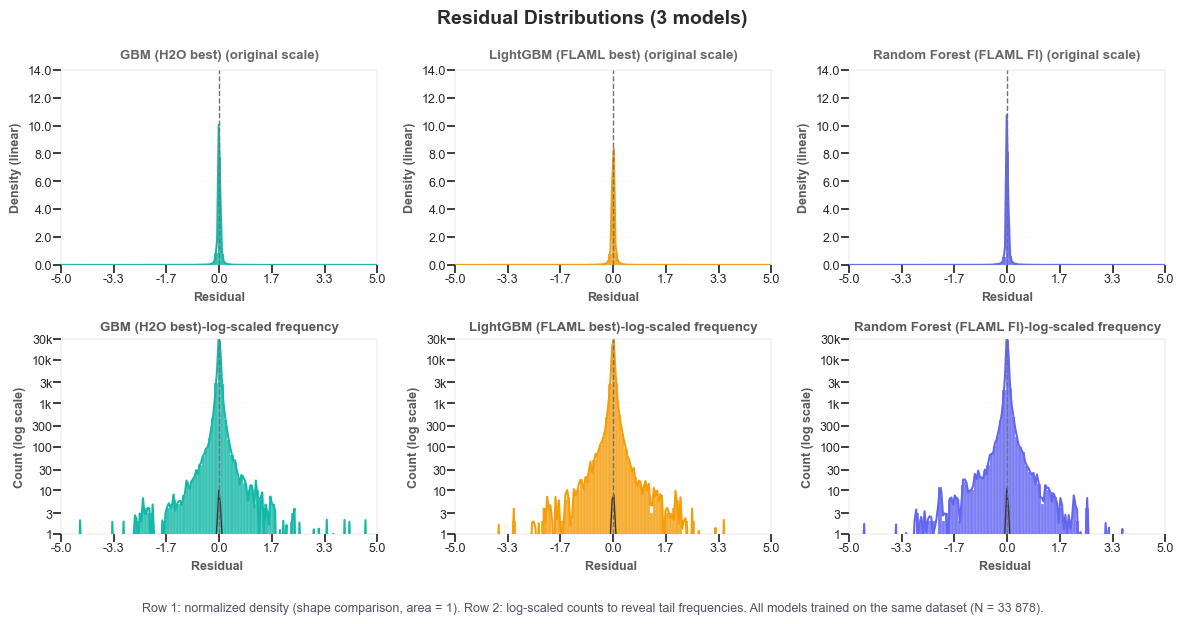

In [34]:
# ---------- data prep (unchanged) ----------
models, xy_min, xy_max, r_abs = prepare_aligned(models_raw)
residuals = [d["Residual"].to_numpy() for _, d, _ in models]
r_all = np.concatenate(residuals)

# identical, wide x-limits for both rows
r_lim = float(np.percentile(np.abs(r_all), 99.995))
r_lim = max(r_lim, 2.0)
xlim = (-r_lim, r_lim)
bins = np.linspace(*xlim, 100)
xticks = np.linspace(-r_lim, r_lim, 7)

# formatters
def short_k(v, p):
    # compact labels to avoid squashing on log y-axis
    v = int(round(v))
    if v >= 1000:
        if v % 1000 == 0:
            return f"{v//1000}k"
        return f"{v/1000:.1f}k"
    return f"{v}"

def polish(ax):
    ax.grid(axis="y", alpha=0.50, linewidth=0.1)
    for s in ax.spines.values():
        s.set_linewidth(0.15)
        s.set_color("#9AA0A6")
    ax.tick_params(labelsize=9, pad=0.2)

# colors
model_colors = ["#14B8A6", "#F59E0B", "#6366F1"]

# ---------- figure ----------
sns.set_style("white"); sns.set_context("talk") ; sns.set_theme(style="ticks") 
fig, axes = plt.subplots(2, 3, figsize=(12.5, 7), sharex=False)
fig.suptitle("Residual Distributions (3 models)", color = TITLE_CLR, fontsize=14, weight="bold", y=0.88)

# ========== Row 1: linear density ==========
for j, ((name, df, _), r, c) in enumerate(zip(models, residuals, model_colors)):
    ax = axes[0, j]
    sns.histplot(r, bins=bins, stat="density", kde=True,
                color=c, alpha=0.9, edgecolor="white", linewidth=0.1, ax=ax)
    ax.axvline(0, color="#6B7280", ls="--", lw=1)
    ax.set_xlim(*xlim)
    ax.set_ylim(0, 14)                                     # requested 0..14
    ax.set_yticks(np.linspace(0, 14, 8))
    ax.set_yticklabels([f"{y:.1f}" for y in np.linspace(0, 14, 8)])
    ax.set_xticks(xticks)                                   # <- force x-ticks shown
    ax.set_xticklabels([f"{t:.1f}" for t in xticks])
    ax.set_title(f"{name} (original scale)", fontsize=9.5, color = SUBTITLE_CLR, weight = "semibold", pad=8)
    ax.set_xlabel("Residual", fontsize=9, color = AXIS_TEXT_CLR, weight = "semibold")
    ax.set_ylabel("Density (linear)", fontsize=9, color = AXIS_TEXT_CLR, weight = "semibold")
    polish(ax)

# ========== Row 2: log-counts + thin KDE ==========
log_ticks = [1, 3, 10, 30, 100, 300, 1_000, 3_000, 10_000, 30_000]
for j, ((name, df, _), r, c) in enumerate(zip(models, residuals, model_colors)):
    ax = axes[1, j]
    sns.histplot(r, bins=bins, stat="count", color=c, alpha=0.85, kde=True, 
                edgecolor="white", linewidth=0.1, ax=ax)
    sns.kdeplot(r, color="#333333", lw=1.0, ax=ax)          # shape overlay
    ax.set_yscale("log")
    ax.set_ylim(1, 20_000)                                  # same cap across all models
    ax.set_yticks(log_ticks)
    ax.yaxis.set_major_formatter(FuncFormatter(short_k))    # compact ticks: 1k, 3k, 10k, 20k
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(which='minor', left=False, right=False, bottom=False, top=False)
    ax.axvline(0, color="#6B7280", ls="--", lw=1)
    ax.set_xlim(*xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{t:.1f}" for t in xticks])
    ax.set_title(f"{name}-log-scaled frequency", fontsize=9.5, color = AXIS_TEXT_CLR, weight = "semibold", pad=6)
    ax.set_xlabel("Residual ", fontsize=9, color = AXIS_TEXT_CLR, weight = "semibold")
    ax.set_ylabel("Count (log scale)", fontsize=9, color = AXIS_TEXT_CLR, weight = "semibold")
    polish(ax)

# KPI footnote
foot = ("Row 1: normalized density (shape comparison, area = 1). "
        "Row 2: log-scaled counts to reveal tail frequencies. "
        "All models trained on the same dataset (N = 33 878).")
plt.figtext(0.14, 0.016, foot, ha="left", va="bottom", fontsize=9, color="#4B5563")

plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])

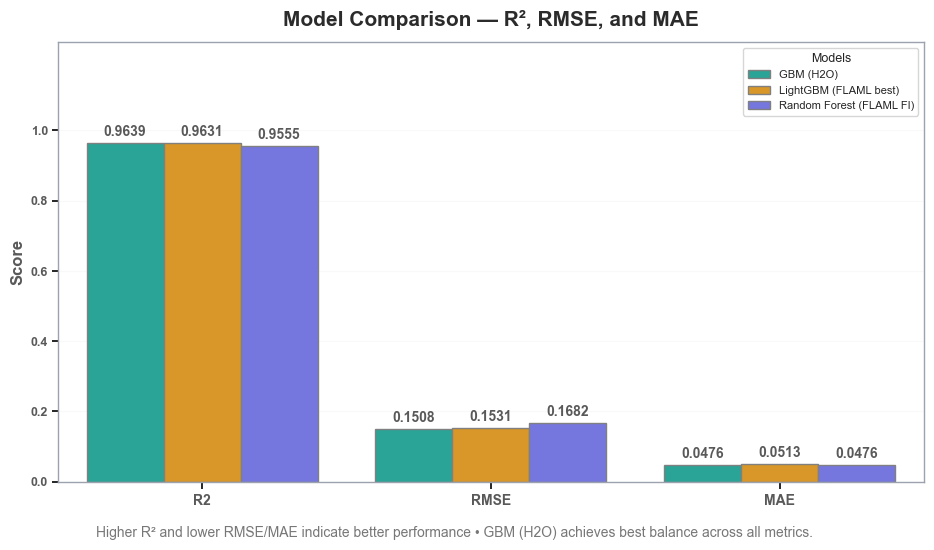

In [ ]:
# =====================
# input KPIs
# =====================
metrics = [
    {"Model": "GBM (H2O)", "R2": 0.9639, "RMSE": 0.1508, "MAE": 0.0476},
    {"Model": "LightGBM (FLAML best)", "R2": 0.9631, "RMSE": 0.1531, "MAE": 0.0513},
    {"Model": "Random Forest (FLAML FI)", "R2": 0.9555, "RMSE": 0.1682, "MAE": 0.0476},
]

df = pd.DataFrame(metrics)

# =====================
# Plot setup
# =====================
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_theme(style="ticks") 

# Define colors (consistent with earlier visuals)
palette = {
    "GBM (H2O)": "#14B8A6",  # teal
    "LightGBM (FLAML best)": "#F59E0B",  # amber
    "Random Forest (FLAML FI)": "#6366F1"  # indigo
}

# Melt for grouped plotting
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# =====================
# Create figure
# =====================
fig, ax = plt.subplots(figsize=(9.5, 5.8))

sns.barplot(
    data=df_melted,
    x="Metric", y="Value", hue="Model",
    palette=palette, ax=ax, edgecolor="grey", linewidth=1
)

# =====================
# Annotate each bar
# =====================
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge", fontsize=10, padding=3, color=AXIS_TEXT_CLR, weight = "semibold")

# =====================
# Formatting
# =====================
ax.set_title("Model Comparison — R², RMSE, and MAE", fontsize=15, weight="bold", color = TITLE_CLR, pad=12)
ax.set_ylabel("Score", fontsize=12, weight="semibold", color = AXIS_TEXT_CLR)
ax.set_xlabel("")
ax.tick_params(axis='x', which='both', labelsize=9, width=1.2, length=5, color='black')
ax.tick_params(axis='y', which='both', labelsize=9, width=1.2, length=4, color='black', pad=3)
ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=10, weight='semibold', color=AXIS_TEXT_CLR)
y_max = 1.0  # maximum limit
ax.set_ylim(0, y_max*1.25)
ax.set_yticks(np.linspace(0, y_max, 6))  
ax.set_yticklabels([f"{y:.1f}" for y in np.linspace(0, y_max, 6)],
                fontsize=9, color=AXIS_TEXT_CLR, weight="semibold")
ax.legend(title="Models", title_fontsize=9, fontsize=8, frameon=True, loc="upper right")
# cosmetics
for spine in ax.spines.values():
    spine.set_linewidth(1.0); spine.set_color("#9CA3AF")
ax.grid(axis="y", alpha=0.1)

# =====================
# Footnote
# =====================
plt.figtext(0.11, 0.01,
            "Higher R² and lower RMSE/MAE indicate better performance • "
            "GBM (H2O) achieves best balance across all metrics",
            ha="left", fontsize=10, color=FOOTNOTE_CLR)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Based on the visual comparison of 3 best models, the GBM (H2O) model demonstrates the best overall performance. It achieves the highest R² score and the lowest RMSE values among the models, indicating that it provides the most stable and accurate predictions. So, GBM (H2O) is the final best model

**Interpreting of final best model GBM(H2O)**

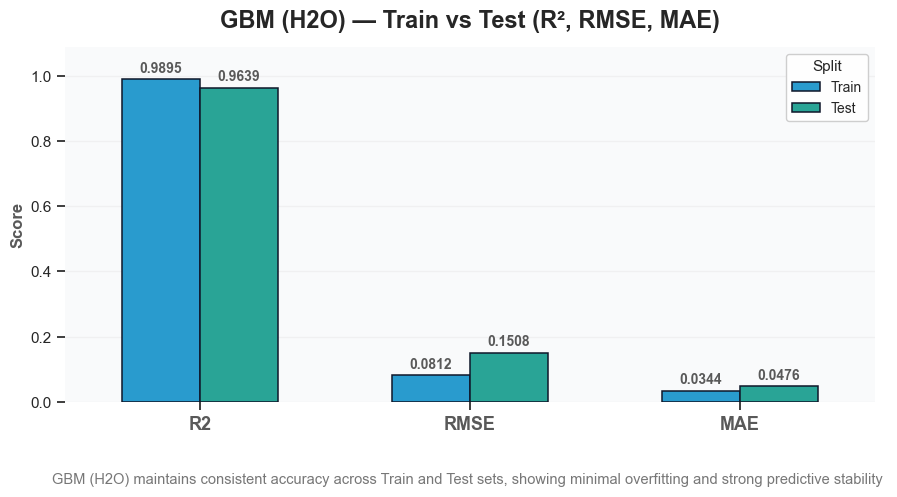

In [52]:
# -----------------------------
# Data (Test + Train for 1 model)
# -----------------------------
data = [
    # Test scores 
    {"Split": "Test",  "Metric": "R2",   "Value": 0.9639},
    {"Split": "Test",  "Metric": "RMSE", "Value": 0.1508},
    {"Split": "Test",  "Metric": "MAE",  "Value": 0.0476},

    # Train scores 
    {"Split": "Train", "Metric": "R2","Value": 0.9895},
    {"Split": "Train", "Metric": "RMSE", "Value": 0.0812},
    {"Split": "Train", "Metric": "MAE",  "Value": 0.0344},
]
df = pd.DataFrame(data)

# Keep a consistent order
metric_order = ["R2", "RMSE", "MAE"]
split_order  = ["Train", "Test"]

# -----------------------------
# Style
# -----------------------------
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_theme(style = "ticks")

fig, ax = plt.subplots(figsize=(9.5, 5.8))

palette = {
    "Train": "#0EA5E9",  # azure-ish
    "Test":  "#14B8A6",  # teal 
}

bars = sns.barplot(
    data=df, x="Metric", y="Value", hue="Split",
    order=metric_order, hue_order=split_order,
    palette=palette, edgecolor="#0F172A", linewidth=1.1, width=0.58, ax=ax
)

# -----------------------------
# Value labels on bars
# -----------------------------
for container in bars.containers:
    bars.bar_label(container, fmt="%.4f", label_type="edge",
                fontsize=10, color=AXIS_TEXT_CLR,  weight = "semibold", padding=3)

# -----------------------------
# Titles & axes
# -----------------------------
ax.set_title("GBM (H2O) — Train vs Test (R², RMSE, MAE)",
            fontsize=17, fontweight="bold", pad=14)
ax.set_xlabel("")
ax.set_ylabel("Score", fontsize=12, color=AXIS_TEXT_CLR, weight = "semibold")
ax.set_ylim(0, df["Value"].max() * 1.1)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, fontweight="semibold", color=AXIS_TEXT_CLR)

# Legend
leg = ax.legend(title="Split", title_fontsize=11, fontsize=10, frameon=True,
                loc="upper right", bbox_to_anchor=(1, 1.0))
leg.get_frame().set_alpha(0.95)

# Minimalist polish
sns.despine(left=True, bottom=True)
ax.set_facecolor("#F9FAFB")
ax.grid(axis= 'y', alpha=0.2)

# Caption
ax.text(
    0.5, -0.22,
    "GBM (H2O) maintains consistent accuracy across Train and Test sets, showing minimal overfitting and strong predictive stability ",
    ha="center", va="center", fontsize=10.5, color=FOOTNOTE_CLR, transform=ax.transAxes
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

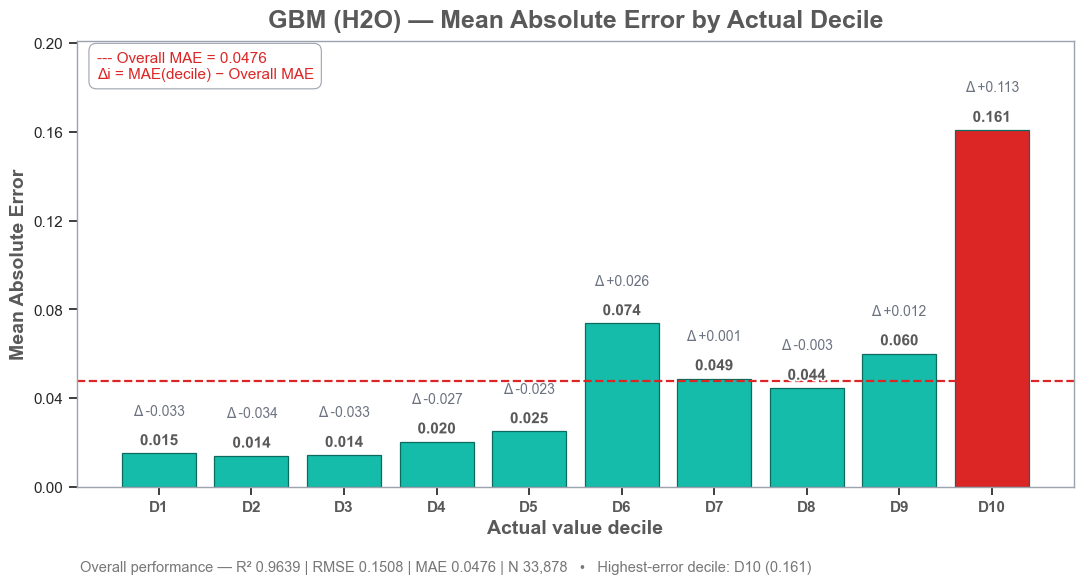

In [58]:
from matplotlib import ticker as mtick

# --- helper (you already have this; kept here so the cell runs standalone) ---
def kpis(df):
    y, yhat = df["Actual"].to_numpy(), df["Predicted"].to_numpy()
    r = yhat - y
    r2   = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)
    rmse = float(np.sqrt(np.mean((y - yhat)**2)))
    mae  = float(np.mean(np.abs(r)))
    return dict(r2=r2, rmse=rmse, mae=mae, n=len(df))

# --- refined visual ---
def mae_by_decile_refined(df, model_name="GBM (H2O)", n_bins=10):
    d = df.copy()
    d["Residual"] = d["Predicted"] - d["Actual"]
    labels = [f"D{i}" for i in range(1, n_bins + 1)]
    d["decile"] = pd.qcut(d["Actual"], q=n_bins, labels=labels, duplicates="drop")

    by = (
        d.assign(abs_err=lambda x: x["Residual"].abs())
        .groupby("decile", observed=True)["abs_err"]
        .mean()
        .reindex(labels)
    )

    kp = kpis(d)
    overall = kp["mae"]

    # style
    sns.set_style("white")
    sns.set_context("talk")
    sns.set_theme(style = "ticks")
    teal   = "#16BCAA"   # bars
    edge   = "#0B6B5E"   # bar edge
    red_hi = "#DC2626"   # highlight
    grey   = "#6B7280"
    gridc  = "#E5E7EB"

    # worst decile
    hi_idx = int(np.argmax(by.values))
    colors = [teal if i != hi_idx else red_hi for i in range(len(by))]

    fig, ax = plt.subplots(figsize=(11, 6.2))

    # bars
    bars = ax.bar(by.index, by.values, color=colors, edgecolor=edge, linewidth=0.9)
    # tweak x-axis tick labels
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=11, color=AXIS_TEXT_CLR, weight="semibold")       

    # y-limits & ticks
    top = max(by.values.max(), overall) * 1.25
    ax.set_ylim(0, top)
    ax.yaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.3f"))

    # subtle grid
    # ax.grid(axis="y", color=gridc, linewidth=0.9)
    ax.yaxis.grid(alpha = 0, linewidth=0.9)
    ax.set_axisbelow(True)

    # perfect contrast for labels
    txt_effect = [pe.withStroke(linewidth=2.5, foreground="white")]

    # value labels + deltas
    for rect, v in zip(bars, by.values):
        x = rect.get_x() + rect.get_width()/2
        # main value
        ax.text(x, v + top*0.012, f"{v:.3f}", ha="center", va="bottom",
                fontsize=11, color=AXIS_TEXT_CLR, weight = "semibold", path_effects=txt_effect)
        # delta vs overall (±)
        dv = v - overall
        ax.text(x, v + top*0.08, f"Δ {dv:+.3f}", ha="center", va="bottom",
                fontsize=10, color=grey)

    # overall line + callout (kept outside bar region)
    ax.axhline(overall, color=red_hi, ls="--", lw=1.6)
    ax.text(0.02, 0.91, f"--- Overall MAE = {overall:.4f}"
            f"\nΔi ​= MAE(decile​) − Overall MAE",
            transform=ax.transAxes, ha="left", va="bottom",
            fontsize=11, color=red_hi, fontweight="medium",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#9CA3AF", lw=0.8))

    # titles & labels
    ax.set_title(f"{model_name} — Mean Absolute Error by Actual Decile",
                fontsize=18, weight="bold", color = AXIS_TEXT_CLR, pad=10)
    ax.set_xlabel("Actual value decile", fontsize=14, color = AXIS_TEXT_CLR, weight = "semibold")
    ax.set_ylabel("Mean Absolute Error", fontsize=14, color = AXIS_TEXT_CLR, weight = "semibold")
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))  

    # cosmetics
    for spine in ax.spines.values():
        spine.set_linewidth(1.0); spine.set_color("#9CA3AF")
    ax.tick_params(axis="both", labelsize=11)

    # footnote
    foot = (f"Overall performance — R² {kp['r2']:.4f} | RMSE {kp['rmse']:.4f} | "
            f"MAE {kp['mae']:.4f} | N {kp['n']:,}   •   "           
            f"Highest-error decile: {by.index[hi_idx]} ({by.iloc[hi_idx]:.3f})")
    plt.figtext(0.08, 0.01, foot, ha="left", va="bottom", fontsize=10.5, color=FOOTNOTE_CLR)

    plt.tight_layout(rect=[0, 0.04, 1, 0.95])
    plt.show()

# ---- usage (your dataframe already exists) ----
# df_h2o_predict must contain columns: 'Actual', 'Predicted'
mae_by_decile_refined(df_h2o_predict, model_name="GBM (H2O)")


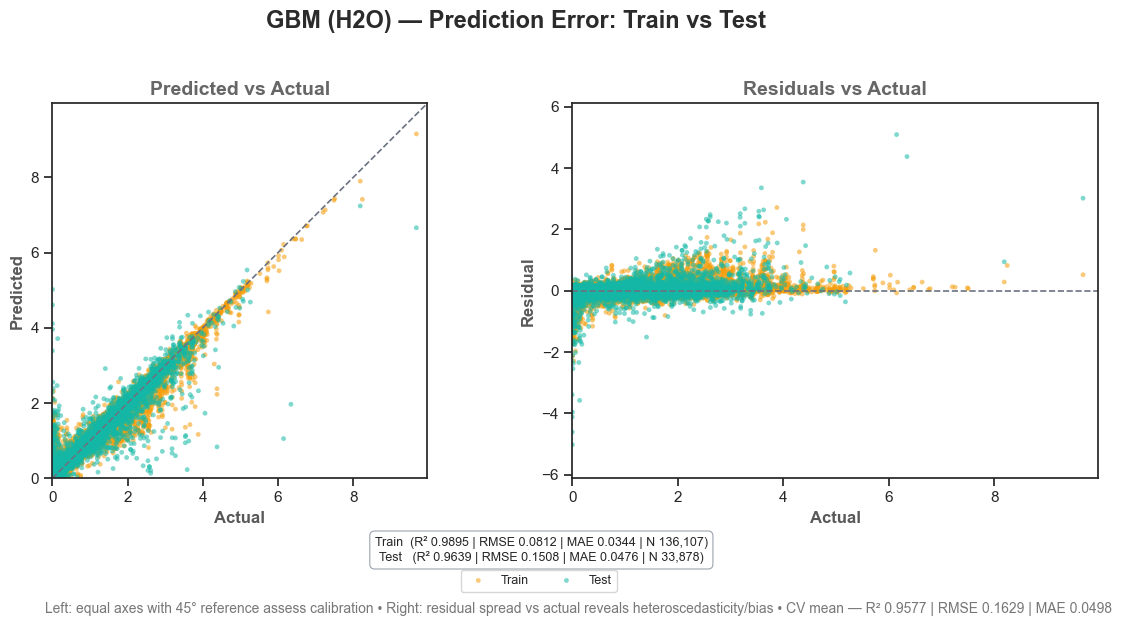

In [63]:
# Load predictions
df_train = df_h2o_predict_train
df_test  = df_h2o_predict

for d in (df_train, df_test):
    if "Residual" not in d.columns:
        d["Residual"] = d["Predicted"] - d["Actual"]

# Train/Test metrics
k_train = dict(r2=0.9895, rmse=0.0812, mae=0.0344, n=len(df_train))
k_test  = dict(r2=0.9639, rmse=0.1508, mae=0.0476, n=len(df_test))

# Cross-validation summary
cv_mean = dict(r2=0.9577, rmse=0.1629, mae=0.0498)
cv_note = f"CV mean — R² {cv_mean['r2']:.4f} | RMSE {cv_mean['rmse']:.4f} | MAE {cv_mean['mae']:.4f}"

# Axes limits
xy_min = max(0.0, float(min(df_train["Actual"].min(), df_test["Actual"].min(),
                            df_train["Predicted"].min(), df_test["Predicted"].min())))
xy_max = float(max(df_train["Actual"].max(), df_test["Actual"].max(),
                   df_train["Predicted"].max(), df_test["Predicted"].max()))
pad = 0.03 * (xy_max - xy_min)
xy_min, xy_max = max(0.0, xy_min - pad), xy_max + pad

r_abs = float(np.max(np.abs(np.concatenate([df_train["Residual"], df_test["Residual"]]))))
r_abs = max(r_abs, 1.0)

# Style
sns.set_style("white")
sns.set_context("talk")
sns.set_theme(style = "ticks")
teal = "#14B8A6"
amber = "#F59E0B"

# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 6))
fig.suptitle("GBM (H2O) — Prediction Error: Train vs Test", fontsize=17, color = TITLE_CLR, weight="bold", y=0.95)

# --- Left: Predicted vs Actual ---
ax1.scatter(df_train["Actual"], df_train["Predicted"], s=12, alpha=0.55, c=amber, edgecolors="none", label="Train")
ax1.scatter(df_test["Actual"], df_test["Predicted"], s=12, alpha=0.55, c=teal, edgecolors="none", label="Test")
ax1.plot([xy_min, xy_max], [xy_min, xy_max], ls="--", lw=1.2, color="#6B7280")
ax1.set_xlim(xy_min, xy_max); ax1.set_ylim(xy_min, xy_max)
ax1.set_aspect("equal", adjustable="box")
ax1.set_xlabel("Actual", weight = "semibold", color = AXIS_TEXT_CLR); ax1.set_ylabel("Predicted", color = AXIS_TEXT_CLR, weight = "semibold")
ax1.set_title("Predicted vs Actual", fontsize = 14,weight="semibold", color = SUBTITLE_CLR)

# --- Right: Residuals vs Actual ---
ax2.scatter(df_train["Actual"], df_train["Residual"], s=12, alpha=0.55, c=amber, edgecolors="none")
ax2.scatter(df_test["Actual"], df_test["Residual"], s=12, alpha=0.55, c=teal, edgecolors="none")
ax2.axhline(0, color="#6B7280", ls="--", lw=1.2)
ax2.set_xlim(xy_min, xy_max);  #ax2.set_ylim(-r_abs, r_abs)
ax2.set_ylim(-r_abs*1.2, r_abs*1.2)
ax2.set_xlabel("Actual", weight = "semibold", color = AXIS_TEXT_CLR); ax2.set_ylabel("Residual", weight = "semibold", color = AXIS_TEXT_CLR)
ax2.set_title("Residuals vs Actual",  fontsize = 14,weight="semibold", color = SUBTITLE_CLR)

# --- KPI Text (Legend-style box under both plots) ---
kpi_text = (
    f"Train  (R² {k_train['r2']:.4f} | RMSE {k_train['rmse']:.4f} | MAE {k_train['mae']:.4f} | N {k_train['n']:,})\n"
    f"Test   (R² {k_test['r2']:.4f} | RMSE {k_test['rmse']:.4f} | MAE {k_test['mae']:.4f} | N {k_test['n']:,})"
)

# Create the KPI box centered below both plots
fig.text(0.52, 0.05, kpi_text, ha="center", va="center",
        fontsize=9, fontweight="medium",
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#9CA3AF", lw=0.8))

# --- Train/Test legend under both plots ---
fig.legend(["Train", "Test"],
        loc="lower center",
        bbox_to_anchor=(0.518, -0.03),
        ncol=2, fontsize=9, frameon=True)

# --- Footnote (CV info and interpretation) ---
note = ("Left: equal axes with 45° reference assess calibration • Right: residual spread vs actual reveals heteroscedasticity/bias • " + cv_note)
plt.figtext(0.55, -0.06, note, ha="center", va="bottom", fontsize=10, color=FOOTNOTE_CLR)

plt.tight_layout(rect=[0.02, 0.06, 0.98, 0.93])

It will be **top 7 absolute residuals** found to detect where the model makes its largest mistakes. This will allow to spot model weaknesses, possible outliers. 

In [64]:
# Create absolute residual column
df_h2o_predict['Absolute Residual'] = df_h2o_predict['Residual'].abs()

# Sort by absolute residual descending
df_sorted = df_h2o_predict.sort_values(by='Absolute Residual', ascending=False)

# Select top 7
top_7 = df_sorted.head(7)

top_7

,Actual,Predicted,Residual,Absolute Residual
32225,6.148368,1.054777,5.093591,5.093591
24018,0.003256,5.021710,-5.018454,5.018454
32141,0.002777,4.609950,-4.607172,4.607172
1894,6.345376,1.968229,4.377147,4.377147
32134,0.001351,4.114241,-4.112889,4.112889
291,0.004681,3.959656,-3.954975,3.954975
23018,0.141360,3.714046,-3.572686,3.572686


Analysis of the top absolute residuals shows that the model struggles the most with rare or unusual cases. These can include special country-occupation combinations, very high or low trade or R&D values, or possible data problems.

An **inverse log transformation** will be applied to bring both actual and predicted values back to their **original scale** for comparison

In [65]:
# Inverse log transform to original scale

df_h2o_predict['Actual_original'] = np.expm1(df_h2o_predict['Actual'])
df_h2o_predict['Predicted_original'] = np.expm1(df_h2o_predict['Predicted'])
# Display only Actual_original and Predicted_original columns
result_table = df_h2o_predict[['Actual_original', 'Predicted_original']]
result_table.head(10)  

,Actual_original,Predicted_original
0,-0.105823,-0.073764
1,-0.115009,-0.099523
2,-0.096689,-0.101832
3,0.300140,0.322798
4,2.345406,3.815684
5,-0.138418,-0.197584
6,-0.405375,-0.381412
7,3.142014,3.279182
8,-0.325309,-0.343020
9,-0.325309,-0.342234


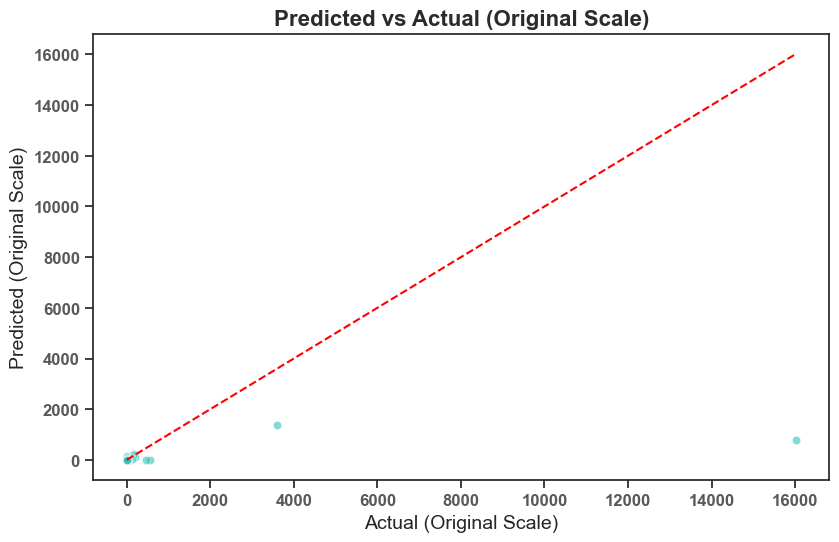

In [68]:
# plot Predicted vs Actual in original scale
plt.figure(figsize=(9.5, 5.8))
sns.scatterplot(
    x=df_h2o_predict['Actual_original'],
    y=df_h2o_predict['Predicted_original'],
    color='#2EC4B6',
    alpha=0.6
)

# 45-degree line for perfect predictions
min_val = min(df_h2o_predict['Actual_original'].min(), df_h2o_predict['Predicted_original'].min())
max_val = max(df_h2o_predict['Actual_original'].max(), df_h2o_predict['Predicted_original'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

plt.xlabel("Actual (Original Scale)", fontsize=14)
plt.ylabel("Predicted (Original Scale)", fontsize=14)
plt.title("Predicted vs Actual (Original Scale)", fontsize=16, color = TITLE_CLR, weight = "bold")
plt.xticks(fontsize=12, color = AXIS_TEXT_CLR, weight = "semibold")
plt.yticks(fontsize=12, color = AXIS_TEXT_CLR, weight = "semibold")
plt.grid(False)

Using all data, extreme values stretch the scale and compress most points near zero, making the pattern hard to interpret. Therefore, the plot will be **limited to the 0.5th–99.5th percentiles** to reduce the influence of outliers and show the main relationship between actual and predicted values more clearly.

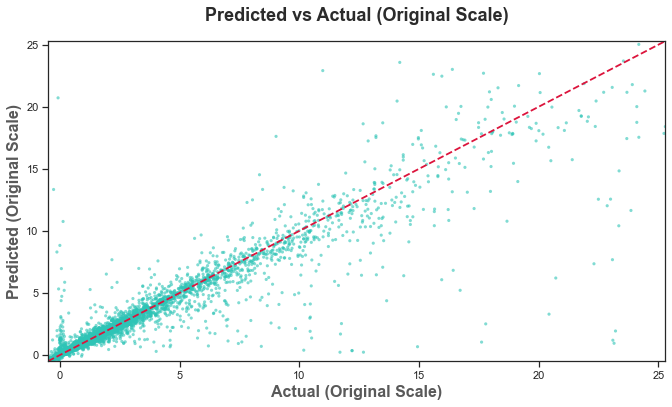

In [ ]:
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("config", "InlineBackend.figure_format = 'png'")
        ip.run_line_magic("config", "InlineBackend.print_figure_kwargs = {'dpi': 72}")
except Exception:
    pass

# Global low-DPI defaults as another guard
mpl.rcParams['figure.dpi']  = 72
mpl.rcParams['savefig.dpi'] = 72
mpl.rcParams['agg.path.chunksize'] = 10000  # split long paths

# ---- 2) (Optional) downsample if many points ----
df = df_h2o_predict  # your dataframe with 'Actual_original' & 'Predicted_original'
cols = ["Actual_original", "Predicted_original"]
df = df.loc[:, cols].dropna()

MAX_POINTS = 20000
if len(df) > MAX_POINTS:
    df_plot = df.sample(MAX_POINTS, random_state=42)
else:
    df_plot = df

# ---- 3) Compute limits with protection against extreme outliers ----
x = df_plot["Actual_original"].to_numpy()
y = df_plot["Predicted_original"].to_numpy()

lo = float(min(np.percentile(x, 0.5), np.percentile(y, 0.5)))
hi = float(max(np.percentile(x, 99.5), np.percentile(y, 99.5)))
if hi <= lo:  # safety
    lo, hi = 0.0, max(x.max(), y.max())

# ---- 4) Plot (small figure, rasterized markers) ----
plt.close('all')
fig, ax = plt.subplots(figsize=(9.5, 5.8), dpi=140)

ax.scatter(
    x, y, s=10, alpha=0.6, c="#2EC4B6",
    edgecolors="none", rasterized=True
)

# 45-degree reference
ax.plot([lo, hi], [lo, hi], ls="--", lw=1.8, color="crimson")

ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_title("Predicted vs Actual (Original Scale)", fontsize=18, weight="bold", color = TITLE_CLR, pad = 20)
ax.set_xlabel("Actual (Original Scale)", fontsize=16, color = AXIS_TEXT_CLR, weight = "semibold")
ax.set_ylabel("Predicted (Original Scale)", fontsize=16, color = AXIS_TEXT_CLR, weight = "semibold")
ax.grid(False)

fig.tight_layout()

The Actual vs Predicted plot on the original scale demonstrates that the model performs well for most industries with smaller occupational shifts. However, it systematically underpredicts extremely large industries with high semiconductor adoption.

**Conclusion:**

In this project, I built a machine learning model to study how semiconductor adoption and technology shifts affect employment growth across countries and industries. After testing multiple models, GBM(H2O) delivered the best results, achieving very high accuracy (R² of 0.9895 on training data and 0.9639 on test data).

The model successfully captured most employment patterns, with only a few larger errors appearing for extreme or rare cases, like unusual country-occupation combinations or extreme trade and R&D values. This means that while the model works very well overall, it may struggle with rare situations not fully covered in the data.

Overall, the model provides strong and reliable predictions, helping to better understand how workforce shifts happen during global technology changes like semiconductor expansion.